In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import cpi
import matplotlib.pyplot as plt
import re
from word2number import w2n
import seaborn as sns
import math

import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()
from collections import Counter

import ast
from matplotlib.pyplot import figure
from distutils.util import strtobool
from matplotlib import rcParams
from numpy import percentile

import pylab 
import scipy as sp
import scipy.stats as stats
import matplotlib.patches as mpatches
from numpy import median

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import random
import string

#### Package setup

In [2]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None
random.seed(123)

## Data Loading, Cleaning, Prepping

#### Load dataset

In [3]:
movies_meta = pd.read_csv("data/movies_metadata.csv")
movies_credits = pd.read_csv("data/credits.csv")
#movies_keywords = pd.read_csv("data/keywords.csv") # Wound up not using keywords so no reason to load

/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
movies_meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [5]:
movies_credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


#### Quickly extract number of franchise films prior to filtering (so we don't accidetly drop sequels)

In [6]:
# Get list of franchise IDs
franchise_id = movies_meta.belongs_to_collection.str.extract(r"'id': (.+?),")
franchise_id.fillna("1", inplace=True)
franchise_id = franchise_id.astype(int)

# Count the number of movies in each franchise
franchies = Counter(franchise_id[franchise_id > 1].dropna(axis = 0)[0])

# Attach franchise movie counts to dataframe
movies_meta['num_franchies_movies'] = franchise_id[0].apply(lambda x: franchies[x])
movies_meta['num_franchies_movies'][movies_meta['num_franchies_movies'] == 0] = 1

#### Clean up dataframe by removing undesired entires and setting correct data types

In [7]:
# Attach credits to main df
movies_credits['id'] = movies_credits['id'].astype(str)
movies_meta = movies_meta.merge(movies_credits, how = 'inner', on = ['id', 'id'])

In [8]:
# Remove undesired entries from database

# Remove movies unreleased at time dataset was collected
movies_meta = movies_meta[movies_meta['status'] == 'Released']

# Remove movies less than 10 minutes in runtime
movies_meta = movies_meta[pd.to_numeric(movies_meta['runtime'], errors='coerce').notnull()]
movies_meta['runtime'] = movies_meta['runtime'].astype(float)
movies_meta = movies_meta[movies_meta['runtime'] >= 10.0]

# Remove movies with less than $1,000,000 revenue
movies_meta = movies_meta[pd.to_numeric(movies_meta['revenue'], errors='coerce').notnull()] # Remove non numeric entries
movies_meta['revenue'] = movies_meta['revenue'].astype(float)
movies_meta = movies_meta[movies_meta['revenue'] > 1000000.0]

# Remove movies with less than $500,000 budget (half of revenue to avoid having a bias for flops)
movies_meta = movies_meta[pd.to_numeric(movies_meta['budget'], errors='coerce').notnull()]
movies_meta['budget'] = movies_meta['budget'].astype(float)
movies_meta = movies_meta[movies_meta['budget'] > 500000.0]

# Set release date to correct data type
movies_meta = movies_meta[movies_meta['release_date'].notna()]
# Convert release_date from string to datetime
movies_meta['release_date'] = movies_meta['release_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

# Only look at movies from 1997 and onwards
movies_meta = movies_meta[movies_meta['release_date'].apply(lambda x: x.year) >= 1997]

movies_meta = movies_meta.reset_index(drop=True)

##### Set correct data types

In [9]:
# Convert strings to proper dictionaries problem with import
movies_meta['genres'] = movies_meta['genres'].apply(lambda x: ast.literal_eval(x))
movies_meta['production_companies'] = movies_meta['production_companies'].apply(lambda x: ast.literal_eval(x))
movies_meta['production_countries'] = movies_meta['production_countries'].apply(lambda x: ast.literal_eval(x))
movies_meta['spoken_languages'] = movies_meta['spoken_languages'].apply(lambda x: ast.literal_eval(x))
movies_meta['crew'] = movies_meta['crew'].apply(lambda x: ast.literal_eval(x))
movies_meta['cast'] = movies_meta['cast'].apply(lambda x: ast.literal_eval(x))
movies_meta['adult'] = movies_meta['adult'].apply(lambda x: strtobool(x))

In [10]:
# Special exception needs for loop to check if null
for i in range(len(movies_meta)):
    # Belongs to collection
    if pd.isnull(movies_meta['belongs_to_collection'][i]) == False:
        movies_meta['belongs_to_collection'][i] = ast.literal_eval(movies_meta['belongs_to_collection'][i])

In [11]:
movies_meta = movies_meta.astype({'adult': 'bool',
                        'id': 'int',
                        'popularity': 'float',
                        'status': 'category'})

#### Add Cinemascores

In [12]:
# Source: https://web.archive.org/web/20190809062201/https://www.cinemascore.com/publicsearch/index/title/
# Open HTML file
with open('data/cinemascore.txt', 'r') as f:
    cinemascore_raw = f.read()

In [13]:
# Grab movie titles and scores then save them as a dataframe
movie_title = re.findall(r'<td class="movie">(.*)<', cinemascore_raw)
scores = re.findall(r'alt="(.*)"/>', cinemascore_raw)
cinemascore = pd.DataFrame({'name' : movie_title, 'cinemascore' : scores}) 

# Clean up, sepearate year and title
cinemascore[['title_upper','year']] = cinemascore.name.str.split("(",expand=True,)
cinemascore = cinemascore.drop("name", axis = 1)
cinemascore['year'] = cinemascore['year'].str.replace(r')', '')

# "An" and "The" need to be move to start of the title
for i in range(len(cinemascore['title_upper'])):
    if bool(re.search(r", AN", cinemascore['title_upper'][i])):
        cinemascore['title_upper'][i] = re.sub(', AN', '', cinemascore['title_upper'][i])
        cinemascore['title_upper'][i] = "AN "+cinemascore['title_upper'][i]
    if bool(re.search(r", THE", cinemascore['title_upper'][i])):
        cinemascore['title_upper'][i] = re.sub(', THE', '', cinemascore['title_upper'][i])
        cinemascore['title_upper'][i] = "THE "+cinemascore['title_upper'][i]
        
# Fix Tyler Perry Movies, remove all ":"s, strip whitespace, put year at the end
cinemascore['title_upper'] = cinemascore['title_upper'].apply(lambda x: re.sub("TYLER PERRY'S ", '', x))
cinemascore['title_upper'] = cinemascore['title_upper'].apply(lambda x: re.sub(":", '', x))
cinemascore['title_upper'] = cinemascore['title_upper'].str.rstrip() + " ("+cinemascore['year']+")"

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/146925907.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cinemascore['year'] = cinemascore['year'].str.replace(r')', '')


In [14]:
cinemascore.head(2)

,cinemascore,title_upper,year
0,B-,10 CLOVERFIELD LANE (2016),2016
1,C,"10,000 B.C. (2008)",2008


In [15]:
# Make column with capitialized title for merging with cinemascore table
movies_meta['title_upper'] = movies_meta['title'].str.upper()
for i in range(len(movies_meta)):
    # Add year to end of title
    movies_meta['title_upper'][i] = movies_meta['title_upper'][i] +" (" + str(movies_meta['release_date'][i].year) + ")"
    # Remove all ":"'s to standardize
    movies_meta['title_upper'][i] = re.sub(":", '', movies_meta['title_upper'][i])

In [16]:
# Fuzzy join cinmeascore and imdb tables
movies = pd.merge(movies_meta, cinemascore, left_on = ['title_upper'], right_on= ['title_upper'], how = 'left')
movies = movies.drop("title_upper", axis = 1)

In [17]:
print ("Number of properly attacheed cinemascore movies " 
       + str(len(np.where(pd.isnull(movies['cinemascore']) == False)[0])) 
       +"/"
       +str(len(cinemascore['title_upper'].unique()))
       +' = '
       + str (len(np.where(pd.isnull(movies['cinemascore']) == False)[0]) / len(cinemascore['title_upper'].unique()))
      )

Number of properly attacheed cinemascore movies 1922/4122 = 0.46627850557981565


#### Load average movie ticket price per year table

In [18]:
# Source: https://www.natoonline.org/data/ticket-price/
# Open HTML file
with open('data/ticket_price_year.txt', 'r') as f:
    ticket_raw = f.read()

In [19]:
# Grab year and ticket price and save them in a table
t_year = pd.to_numeric(re.findall(r'<td class="column-1">(.*)</td><td', ticket_raw))
t_price = pd.to_numeric(re.findall(r'<td class="column-2">[$](.*)</td>', ticket_raw))
ticket_price = pd.DataFrame({'year' : t_year, 'avg_ticket_price' : t_price}) 

In [274]:
ticket_price.head(3)

,year,avg_ticket_price
0,2019,9.16
1,2018,9.11
2,2017,8.97


#### Generate new columns from existing columns in the dataframe

In [21]:
# Estimate profit from rule of thumb
movies['est_profit'] = (movies['revenue'] - movies['budget']*2)

# Proportion of returns
movies['returns_ratio'] = movies['est_profit']/movies['budget']

# Create sentimentality score for movie description
movies['overview_sentiment'] = movies['overview'].apply(lambda x:  sid_obj.polarity_scores(str(x))['compound'] )

In [22]:
movies['revenue_adjusted'] = np.nan
movies['est_profit_adjusted'] = np.nan
movies['budget_adjusted'] = np.nan
movies['est_tickets'] = np.nan
movies['budget_tickets'] = np.nan
movies['prof_tickets'] = np.nan

# for loop is slow but easier to write to run since year must be extracted or checked
for i in range(len(movies)):
    
    # Get year of movie release
    i_year = movies['release_date'][i].year
    
    # Adjust revenue for inflation
    movies['revenue_adjusted'][i] =  cpi.inflate(movies['revenue'][i], i_year, to=2017)

    movies['est_profit_adjusted'][i] =  cpi.inflate(movies['est_profit'][i], i_year, to=2017)

    movies['budget_adjusted'][i] =  cpi.inflate(movies['budget'][i],
                                              i_year,
                                              to=2017)

    movies['budget_adjusted'][i] =  cpi.inflate(movies['budget'][i],
                                      i_year,
                                      to=2017)
        
    # Calculate esitmated tickets sales based on revenue and avg ticket price for the year
    if i_year >= 1975:
        cur_ticket_price = ticket_price['avg_ticket_price'][ticket_price['year'] == i_year].iloc[0]
        ticket_sales = movies['revenue'][i] / cur_ticket_price
        movies['est_tickets'][i] = ticket_sales
        
        movies['budget_tickets'][i] = movies['budget'][i] / cur_ticket_price
        
        break_even_ticket_sales = (movies['budget'][i] * 2) / cur_ticket_price
        movies['prof_tickets'][i] = ticket_sales - break_even_ticket_sales

In [23]:
# Create numeric column for cinemascores
movies['cinemascore_num'] = movies['cinemascore']
rep = {'cinemascore_num': {"A+":13 , "A": 12, "A-": 11, "B+": 10, "B": 9, "B-": 8,
       "C+": 7, "C": 6, "C-": 5, "D+": 4, "D": 3, "D-": 2, "F": 1}}
movies = movies.replace(rep)

In [24]:
# Drop rows with no credits
movies = movies[movies['crew'].map(lambda x: len(x)) > 0]
movies = movies.reset_index(drop = True)

# Extractor director name
movies['director'] = movies['crew'].apply(
    lambda x: next(item for item in x if item["job"] == "Director")['name']
)

#### Re-order columns

In [25]:
print(len(movies.columns))
movies.columns

40


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'num_franchies_movies', 'cast', 'crew',
       'cinemascore', 'year', 'est_profit', 'returns_ratio',
       'overview_sentiment', 'revenue_adjusted', 'est_profit_adjusted',
       'budget_adjusted', 'est_tickets', 'budget_tickets', 'prof_tickets',
       'cinemascore_num', 'director'],
      dtype='object')

In [26]:
# reorder columns by hand to be easier to interpret
new_col_order = ['original_title', 'title', 'director', 'release_date', 'revenue', 'revenue_adjusted', 'budget', 'budget_adjusted',
                 'est_profit', 'est_profit_adjusted', 'returns_ratio', 'est_tickets', 'budget_tickets', 'prof_tickets', 'vote_count',
                 'vote_average', 'cinemascore', 'cinemascore_num', 'genres', 'runtime', 'belongs_to_collection',
                 'num_franchies_movies', 'original_language',
                 'spoken_languages', 'production_countries', 'production_companies', 'overview',
                 'overview_sentiment', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 
                 'homepage', 'poster_path']
print(len(new_col_order))

# Popularity re-calculated to be weekly popularity so it's a bad metric

movies = movies[new_col_order]

35


In [27]:
movies.head(3)

,original_title,title,director,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path
0,The Relic,The Relic,Peter Hyams,1997-01-10,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.8020,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg
1,Shadow Conspiracy,Shadow Conspiracy,George P. Cosmatos,1997-01-31,2154540.0,3.290473e+06,45000000.0,6.872523e+07,-87845460.0,-1.341600e+08,-1.952121,4.693987e+05,9.803922e+06,-1.913844e+07,12.0,4.0,NaN,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",103.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Hollywood Pictures', 'id': 915}, {'...",Bobby Bishop (Sheen) is a special assistant to...,-0.8020,NaN,Released,3.733574,38153,tt0120107,NaN,/w1MCRsbCAIdOTobSmoU9KIEvZKF.jpg
2,Turbulence,Turbulence,Robert Butler,1997-01-09,11466088.0,1.751132e+07,55000000.0,8.399751e+07,-98533912.0,-1.504837e+08,-1.791526,2.498058e+06,1.198257e+07,-2.146708e+07,63.0,5.2,B-,8.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",100.0,"{'id': 166379, 'name': 'Turbulence Collection'...",2,en,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","On a flight transporting dangerous convicts, m...",-0.9201,"If you weren't afraid of flying before, you wi...",Released,5.304043,34314,tt0120390,NaN,/n1U5lOvu6wSOQwdgSx2Yh41THdi.jpg


## Quick and Dirty Correlation plot

In [29]:
movies_corr_values = movies.drop(['original_title', 'title', 'release_date', 'cinemascore', 'genres',
                                'belongs_to_collection', 'spoken_languages', 'production_companies', 
                                'overview', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 'homepage',
                                'poster_path', 'director'], axis = 1)

# Replace language with in_english t/f
movies_corr_values['in_english'] = (movies_corr_values['original_language'] == 'en')

# Replace country with from_usa t/f
movies_corr_values['from_usa'] = False
index_i = 0
for i in movies_corr_values['production_countries']:
    # Need to dig dicitonary out of list
    for j in i:
        movies_corr_values['from_usa'][index_i] = (j['name'] == "United States of America")
    index_i = index_i + 1

    
#movies_corr_values = movies_corr_values.drop(["original_language", "production_countries"], axis =1)
movies_corr_values.reset_index(drop = True,  inplace=True)

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1172782890.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(movies_corr, dtype=np.bool))


<AxesSubplot:>

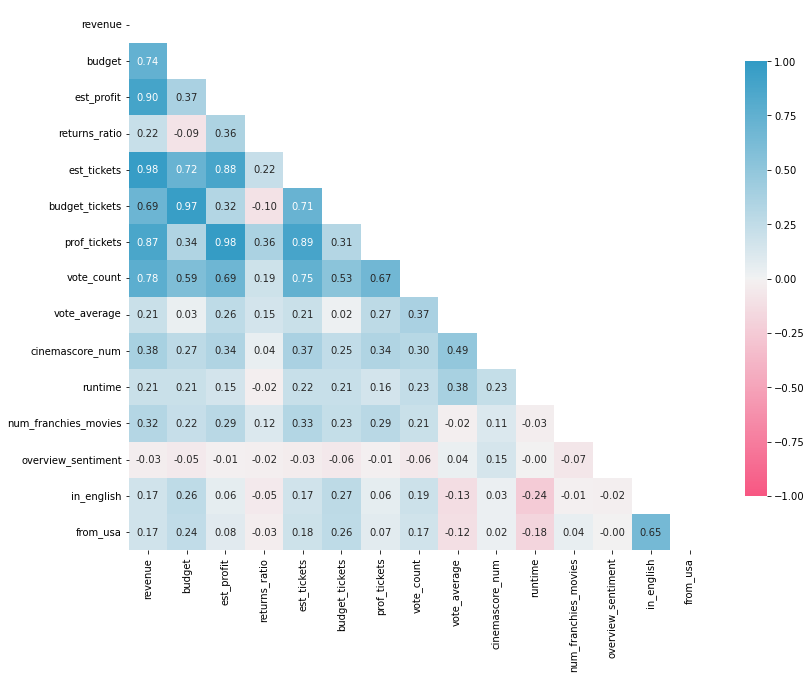

In [30]:
movies_corr_unadjusted = movies_corr_values.drop(['revenue_adjusted', 'budget_adjusted', 'est_profit_adjusted'], axis = 1)

movies_corr = movies_corr_unadjusted.corr(method ='pearson')
mask = np.triu(np.ones_like(movies_corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(13,10)) 

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(movies_corr, mask=mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})

#plt.imshow(movies_corr, cmap='hot', interpolation='nearest')


## Prepping data for feature plotting

#### Make two df's, one to hold all movies (imdb_scoring), one to hold only rows that have cinemascores (cinemascore_only)

In [31]:
cinemascore_only = movies.copy(deep = True)
imdb_scoring = movies.copy(deep = True).reset_index(drop=True) 

# Remove rows with no cinemascore
cinemascore_only = cinemascore_only[cinemascore_only['cinemascore'].notna()]
cinemascore_only = cinemascore_only.reset_index(drop=True) 


# Create cinemascore brackets to boil movies into a score/5 (based on quantiles of scoring distributions)
cinemascore_only['cinemascore_rank'] = cinemascore_only['cinemascore']
rep = {'cinemascore_rank': {"A+": 1, "A": 1, "A-": 2, "B+": 3, "B": 4, "B-": 4,
       "C+": 5, "C": 5, "C-": 5, "D+": 5, "D": 5, "D-": 5, "F": 5}}
cinemascore_only = cinemascore_only.replace(rep)


# Remove outliers
# q1 = cinemascore_only['revenue'].quantile(0.25)
# q3 = cinemascore_only['revenue'].quantile(0.75)
# iqr = q3-q1
# low  = q1-1.5*iqr
# high = q3+1.5*iqr
# cinemascore_only_no_outlier = cinemascore_only.loc[(cinemascore_only['revenue'] > low) & (cinemascore_only['revenue'] < high)]

In [32]:
# Create column of the brackets for the different movie scores
imdb_scoring['vote_bracket'] = np.nan

vote_percentiles = percentile(imdb_scoring['vote_average'], [20, 40, 60, 80])

for i in range(len(imdb_scoring)):
    if imdb_scoring['vote_average'][i] >= vote_percentiles[3]:
        imdb_scoring['vote_bracket'][i] = 1
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[2]:
        imdb_scoring['vote_bracket'][i] = 2
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[1]:
        imdb_scoring['vote_bracket'][i] = 3
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[0]:
        imdb_scoring['vote_bracket'][i] = 4
    else:
        imdb_scoring['vote_bracket'][i] = 5

In [33]:
# Create column of the brackets for the different movie scores
imdb_scoring['budget_bracket'] = np.nan

budget_percentiles = percentile(imdb_scoring['budget_tickets'], [20, 40, 60, 80])

for i in range(len(imdb_scoring)):
    if imdb_scoring['budget_tickets'][i] >= budget_percentiles[3]:
        imdb_scoring['budget_bracket'][i] = 1
    elif imdb_scoring['budget_tickets'][i] >= budget_percentiles[2]:
        imdb_scoring['budget_bracket'][i] = 2
    elif imdb_scoring['budget_tickets'][i] >= budget_percentiles[1]:
        imdb_scoring['budget_bracket'][i] = 3
    elif imdb_scoring['budget_tickets'][i] >= budget_percentiles[0]:
        imdb_scoring['budget_bracket'][i] = 4
    else:
        imdb_scoring['budget_bracket'][i] = 5

In [34]:
imdb_scoring.head(2)

,original_title,title,director,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,budget_bracket
0,The Relic,The Relic,Peter Hyams,1997-01-10,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0,1.0
1,Shadow Conspiracy,Shadow Conspiracy,George P. Cosmatos,1997-01-31,2154540.0,3.290473e+06,45000000.0,6.872523e+07,-87845460.0,-1.341600e+08,-1.952121,4.693987e+05,9.803922e+06,-1.913844e+07,12.0,4.0,NaN,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",103.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Hollywood Pictures', 'id': 915}, {'...",Bobby Bishop (Sheen) is a special assistant to...,-0.802,NaN,Released,3.733574,38153,tt0120107,NaN,/w1MCRsbCAIdOTobSmoU9KIEvZKF.jpg,5.0,2.0


### QQ Plots to check the distribution of each of our metrics

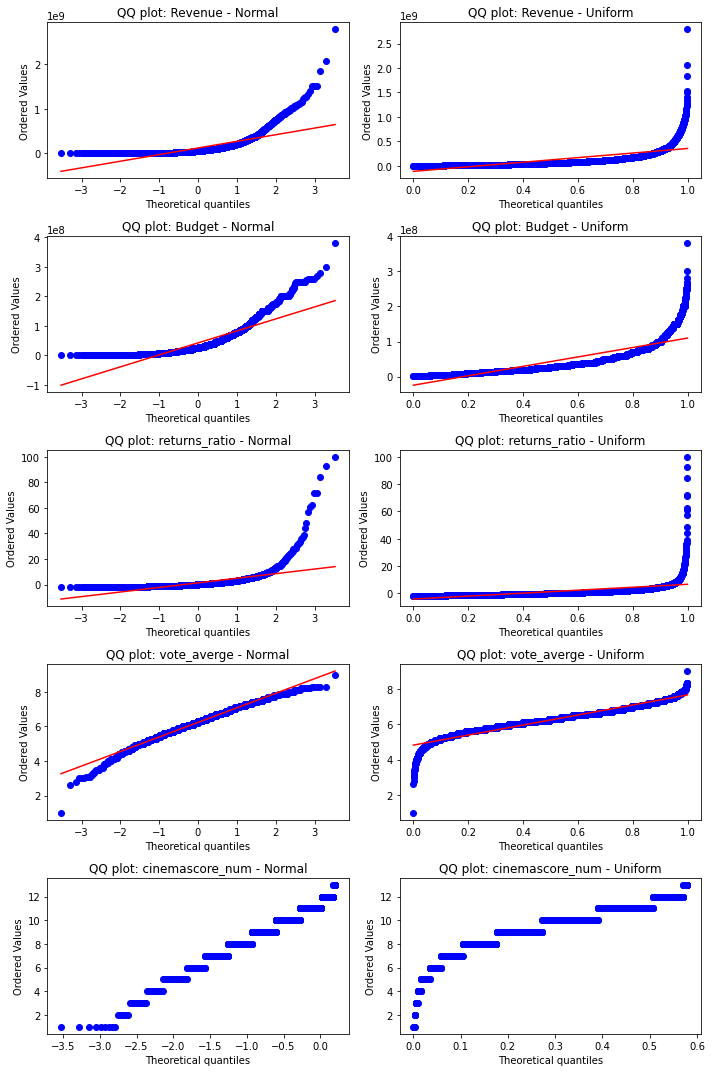

In [35]:
fig, ax = plt.subplots(5,2, figsize=(10,15))

stats.probplot(imdb_scoring['revenue'], dist="norm", plot=ax[0, 0])
ax[0, 0].title.set_text('QQ plot: Revenue - Normal')
stats.probplot(imdb_scoring['revenue'], dist="uniform", plot=ax[0, 1])
ax[0, 1].title.set_text('QQ plot: Revenue - Uniform')

stats.probplot(imdb_scoring['budget'], dist="norm", plot=ax[1, 0])
ax[1, 0].title.set_text('QQ plot: Budget - Normal')
stats.probplot(imdb_scoring['budget'], dist="uniform", plot=ax[1, 1])
ax[1, 1].title.set_text('QQ plot: Budget - Uniform')

stats.probplot(imdb_scoring['returns_ratio'], dist="norm", plot=ax[2, 0])
ax[2, 0].title.set_text('QQ plot: returns_ratio - Normal')
stats.probplot(imdb_scoring['returns_ratio'], dist="uniform", plot=ax[2, 1])
ax[2, 1].title.set_text('QQ plot: returns_ratio - Uniform')

stats.probplot(imdb_scoring['vote_average'], dist="norm", plot=ax[3, 0])
ax[3, 0].title.set_text('QQ plot: vote_averge - Normal')
stats.probplot(imdb_scoring['vote_average'], dist="uniform", plot=ax[3, 1])
ax[3, 1].title.set_text('QQ plot: vote_averge - Uniform')

stats.probplot(imdb_scoring['cinemascore_num'], dist="norm", plot=ax[4, 0])
ax[4, 0].title.set_text('QQ plot: cinemascore_num - Normal')
stats.probplot(imdb_scoring['cinemascore_num'], dist="uniform", plot=ax[4, 1])
ax[4, 1].title.set_text('QQ plot: cinemascore_num - Uniform')

fig.tight_layout()

# FEATURE PLOTTING

#### Cinemascore vs IMDb Score

##### Check if they are the same with a t test

In [36]:
# Dive ticket sales into 4 quantiles
c_20 = cinemascore_only['cinemascore_num'].quantile(0.20)
c_40 = cinemascore_only['cinemascore_num'].quantile(0.40)
c_60 = cinemascore_only['cinemascore_num'].quantile(0.60)
c_80 = cinemascore_only['cinemascore_num'].quantile(0.80)

cinema_bot = cinemascore_only[cinemascore_only['cinemascore_num'] <= c_20]['est_tickets']
cinema_low = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_20) & (cinemascore_only['cinemascore_num'] <= c_40)]['est_tickets']
cinema_mid = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_40) & (cinemascore_only['cinemascore_num'] <= c_60)]['est_tickets']
cinema_high = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_60) & (cinemascore_only['cinemascore_num'] <= c_80)]['est_tickets']
cinema_top = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_80)]['est_tickets']

i_20 = imdb_scoring['vote_average'].quantile(0.20)
i_40 = imdb_scoring['vote_average'].quantile(0.40)
i_60 = imdb_scoring['vote_average'].quantile(0.60)
i_80 = imdb_scoring['vote_average'].quantile(0.80)

imdb_bot = imdb_scoring[imdb_scoring['vote_average'] <= i_20]['est_tickets']
imdb_low = imdb_scoring[(imdb_scoring['vote_average'] > i_20) & (imdb_scoring['vote_average'] <= i_40)]['est_tickets']
imdb_mid = imdb_scoring[(imdb_scoring['vote_average'] > i_40) & (imdb_scoring['vote_average'] <= i_60)]['est_tickets']
imdb_high = imdb_scoring[(imdb_scoring['vote_average'] > i_60) & (imdb_scoring['vote_average'] <= i_80)]['est_tickets']
imdb_top = imdb_scoring[(imdb_scoring['vote_average'] > i_80)]['est_tickets']

print("Cinemascore -> q20: " + str(c_20) +"   q40: "+ str(c_40) + "   q60: " + str(c_60) + "   q80: " + str(c_80))
print("imdb vote -> q20: " + str(i_20) +"   q40: "+ str(i_40) + "   q60: " + str(i_60) + "   q80: " + str(i_80))

Cinemascore -> q20: 8.0   q40: 9.0   q60: 10.0   q80: 11.0
imdb vote -> q20: 5.6   q40: 6.0   q60: 6.5   q80: 7.0


In [37]:
print(np.var(cinema_bot)/np.var(imdb_bot))
print(np.var(cinema_low)/np.var(imdb_low))
print(np.var(cinema_mid)/np.var(imdb_mid))
print(np.var(cinema_high)/np.var(imdb_high))
print(np.var(cinema_top)/np.var(imdb_top))

0.7962986033676784
0.6893820868831978
0.8709444355392608
1.2727390246652892
1.5970018965590809


##### All pairs have a variance between 0.25 and 4 so we can say that there is equal variance in all pairs and run t tests

In [38]:
t_test_pairs = [[cinema_bot, imdb_bot], [cinema_low, imdb_low], [cinema_mid, imdb_mid], [cinema_high, imdb_high], [cinema_top, imdb_top]]
t_tests = [['20th Percentile and Lower'], ['20th to 40th Percentile'], ['40th to 60th Percentile'], ['60th to 80th Percentile'], ['80th Percentile and Above']]

loop_index = 0
for i in t_test_pairs:
    print(t_tests[loop_index])
    loop_index = loop_index+1
    print(stats.ttest_ind(a=i[0], b=i[1], equal_var=True))
    print('\n')

['20th Percentile and Lower']
Ttest_indResult(statistic=0.7887074021243891, pvalue=0.430422761259151)


['20th to 40th Percentile']
Ttest_indResult(statistic=1.9452365865063037, pvalue=0.05206181011268416)


['40th to 60th Percentile']
Ttest_indResult(statistic=3.399159399676517, pvalue=0.0006990814942101226)


['60th to 80th Percentile']
Ttest_indResult(statistic=6.9831260031535605, pvalue=5.1162203770714105e-12)


['80th Percentile and Above']
Ttest_indResult(statistic=6.830761969761654, pvalue=1.673735174467086e-11)




[Text(1, 0, 'F'),
 Text(2, 0, 'D-'),
 Text(3, 0, 'D'),
 Text(4, 0, 'D+'),
 Text(5, 0, 'C-'),
 Text(6, 0, 'C'),
 Text(7, 0, 'C+'),
 Text(8, 0, 'B-'),
 Text(9, 0, 'B'),
 Text(10, 0, 'B+'),
 Text(11, 0, 'A-'),
 Text(12, 0, 'A'),
 Text(13, 0, 'A+')]

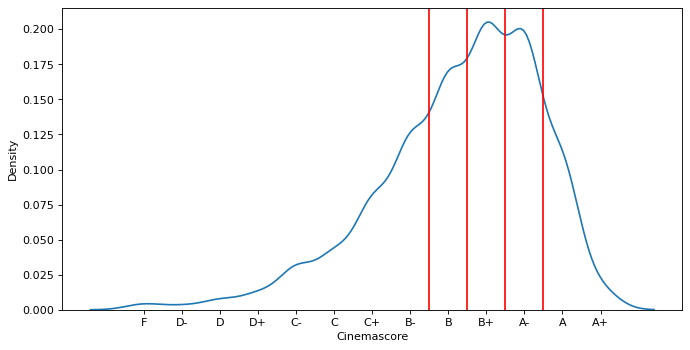

In [39]:
figure(figsize=(10, 5), dpi=80)
#g = sns.histplot(data=cinemascore_only, x="cinemascore_num", kde = True)
g = sns.kdeplot(data=cinemascore_only, x="cinemascore_num")

plt.axvline(c_20 + 0.5, color='r', label = 'Q1')
plt.axvline(c_40 + 0.5, color='r')
plt.axvline(c_60 + 0.5, color='r')
plt.axvline(c_80 + 0.5, color='r')

g.set(xlabel='Cinemascore')

g.set(xticks=np.arange(1,14,1))

g.set_xticklabels(['F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+'])

[[<matplotlib.axis.XTick at 0x1971fd250>,

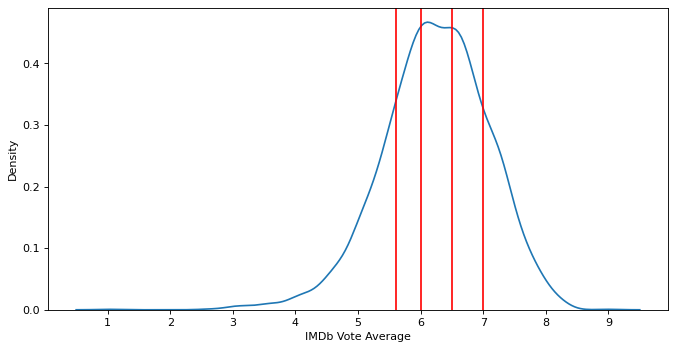

In [40]:
figure(figsize=(10, 5), dpi=80)
#g = sns.histplot(data=cinemascore_only, x="cinemascore_num")
g = sns.kdeplot(data=imdb_scoring, x="vote_average")

plt.axvline(i_20, color='r', label = 'Q1')
plt.axvline(i_40, color='r')
plt.axvline(i_60, color='r')
plt.axvline(i_80, color='r')

g.set(xlabel='IMDb Vote Average')
g.set(xticks=np.arange(1,10,1))

P values are below 0.05 for 25th percentile and up so we have sufficient evidence to say that the same population is not represented by cinemascore and imdb_score

However, 25th percentile and lower has a p_value of 0.70 (cannot reject null hypothesis) so we do not have sufficent evidence to say that the this popuation is different

##### **Conclusion: both populations are not the same for anything but the bottom 25% of movies**

#### Comparing Cinemascore and IMDb Score With Linear Models

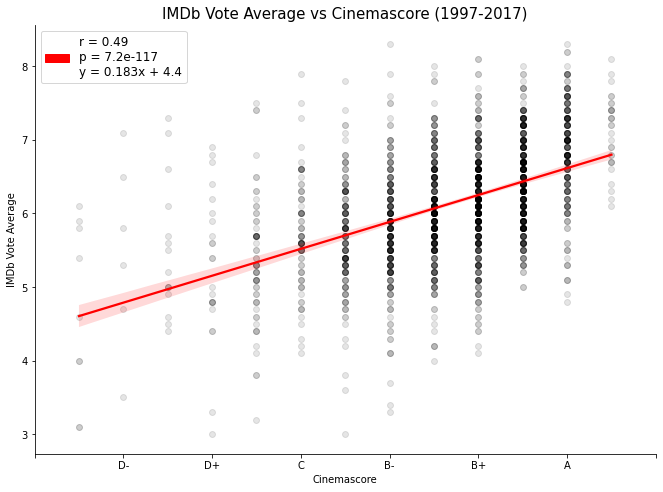

In [41]:
# IMDB Score vs Cinemascore
g = sns.lmplot(x="cinemascore_num", y="vote_average", data=cinemascore_only,
               scatter_kws={'alpha':0.10, "color": "black"},
               line_kws={'color': 'red'})

g.fig.set_size_inches(10,7)
g.set(xlabel='Cinemascore', ylabel='IMDb Vote Average')
g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
plt.title("IMDb Vote Average vs Cinemascore (1997-2017)", fontdict={'size': 15})

# Generate legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(cinemascore_only['cinemascore_num'], cinemascore_only['vote_average'])
legend_text = mpatches.Patch(color='red', label='r = {:.2f}\np = {:.2g}\ny = {:.3g}x + {:.2g}'.format(r_value, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/512514393.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/512514393.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/512514393.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_yticklabels(ylabels)


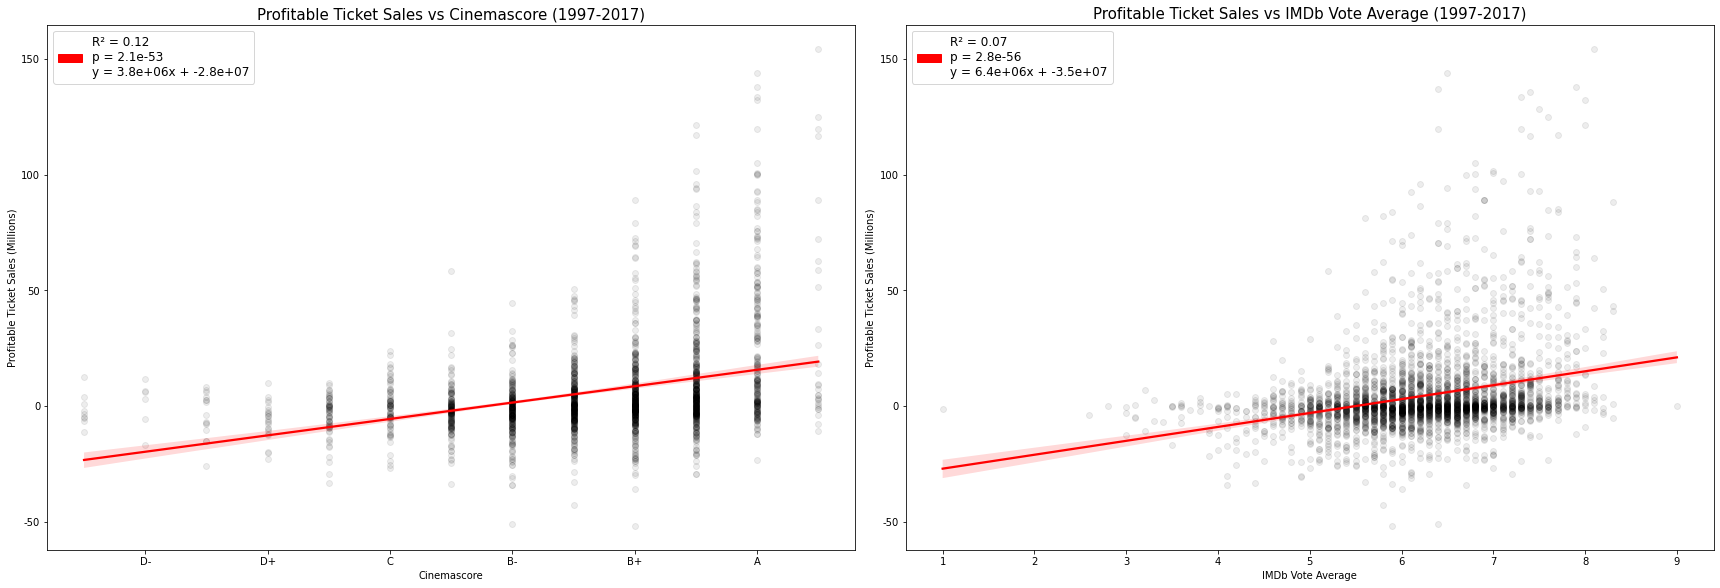

In [42]:
#Estimated Ticket Sales vs Cinemascore
#plt.figure(figsize=(10,7))

fig, ax = plt.subplots(1,2, figsize=(24,8.27))
ax[0].set_title("Profitable Ticket Sales vs Cinemascore (1997-2017)", fontdict={'size': 15})

g = sns.regplot(x="cinemascore_num", y="prof_tickets",
                data=cinemascore_only.sort_values("est_tickets", ascending = False)[2:],
                scatter_kws={'alpha':0.07, "color": "black"},
                line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},
                ax = ax[0]
    )


g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
g.set(xlabel='Cinemascore', ylabel='Profitable Ticket Sales (Millions)')

ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(cinemascore_only['cinemascore_num'], cinemascore_only['prof_tickets'])
legend_text = mpatches.Patch(color='red', label='R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
ax[0].legend(loc='upper left', fontsize = 12, handles=[legend_text])


# Estimated Ticket Sales vs IMDB Score
ax[1].set_title("Profitable Ticket Sales vs IMDb Vote Average (1997-2017)", fontdict={'size': 15})


h = sns.regplot(x="vote_average", y="prof_tickets",
                data=imdb_scoring.sort_values("prof_tickets", ascending = False)[3:],
          scatter_kws={'alpha':0.07, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},
                ax = ax[1]
    )

h.set(xlabel='IMDb Vote Average', ylabel='Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
h.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['vote_average'], imdb_scoring['prof_tickets'])
legend_text = mpatches.Patch(color='red', label='R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
ax[1].legend(loc='upper left', fontsize = 12, handles=[legend_text])

fig.tight_layout()

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2390182886.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


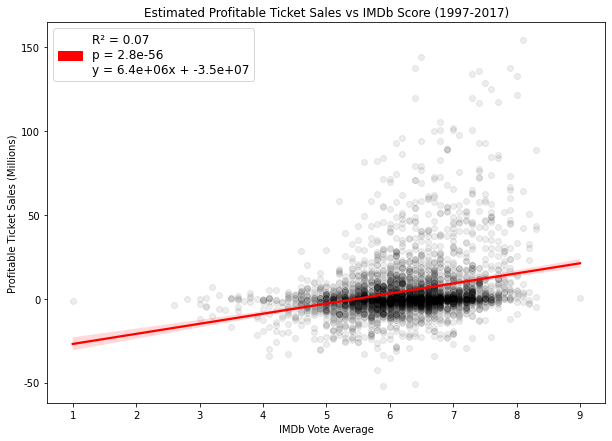

In [43]:
# Estimated Ticket Sales vs IMDB Score
plt.figure(figsize=(10,7))
plt.title("Estimated Profitable Ticket Sales vs IMDb Score (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="vote_average", y="prof_tickets",
                data=imdb_scoring.sort_values("prof_tickets", ascending = False)[3:],
          scatter_kws={'alpha':0.07, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='IMDb Vote Average', ylabel='Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['vote_average'], imdb_scoring['prof_tickets'])
legend_text = mpatches.Patch(color='red', label='R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

In [44]:
# Make equation to quickly generate multi-group lineplot
def lineplot_groups(table, x, y, hue, x_lab, y_lab, title, x_scale, y_scale, palette):
    g = sns.lmplot(x=x, y=y, hue= hue, data=table,
              palette=palette,
              scatter_kws={'alpha':0.1},
              legend = False
        )

    overall_line = sns.regplot(x=x, y=y, data=table, 
                ax=g.axes.flat[0], 
                color="black",
                label='Overall',
                scatter=False,
                ci=68,
                line_kws={'ls':'--'}
                )

    g.fig.set_size_inches(15,10)
    plt.title(title, fontdict={'size': 15})

    # Runs for each line to calculate statistics
    l_stat = []
    def annotate(data, **kws):
        slope, intercept, r, p, std_err = sp.stats.linregress(data[x], data[y])
        slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept),
        r_2 = '{:.2f}'.format(r**2)
        l_stat.append([r_2, slope_eq])
    g.map_dataframe(annotate) 

    # Get overall line stats
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(table[x], table[y])
    r_2 = '{:.2f}'.format(r_value**2)
    slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept)

    # Needed to change properties of plot since we're using "hue" to have multiple groups
    for ax in g.axes.flat:
        ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()/y_scale]
        ax.set_yticklabels(ylabels, fontsize=14)
        xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()/x_scale]
        ax.set_xticklabels(xlabels, fontsize=14)
    
    #g.set(xlabel=x_lab, ylabel=y_lab)
    ax.set_xlabel(x_lab, fontsize=14)
    ax.set_ylabel(y_lab, fontsize=14)
    
    return l_stat, r_2, slope_eq

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


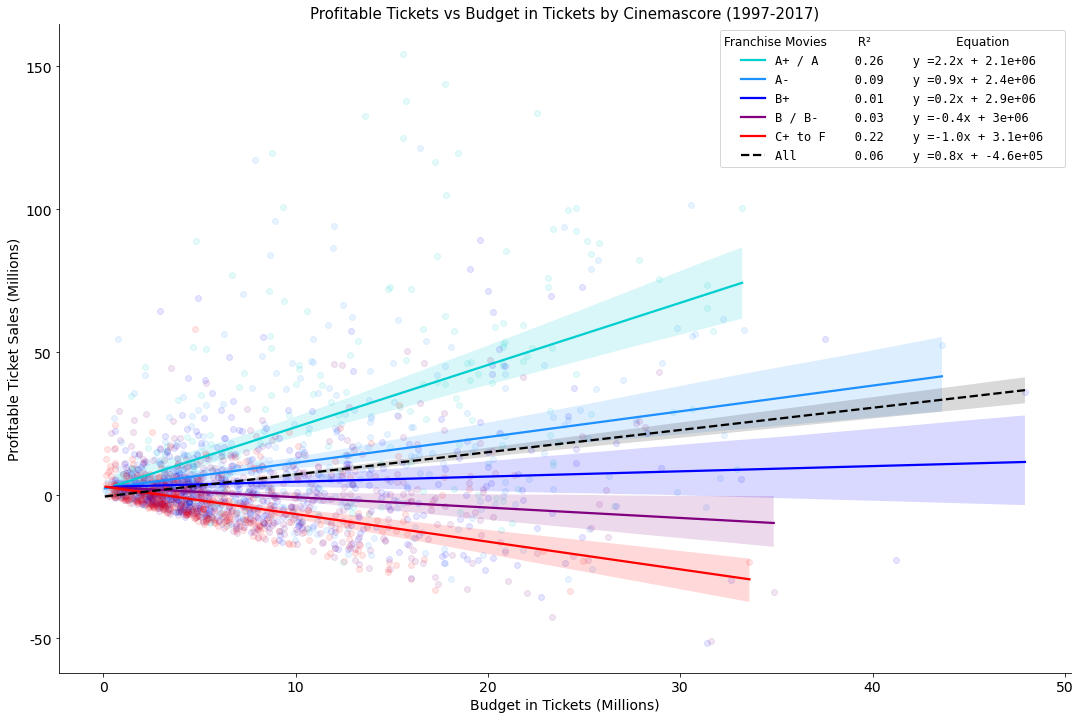

In [45]:
# Revenue vs Budget by Cinemascore
l_stat, r_2, slope_eq = lineplot_groups(
    table = cinemascore_only.sort_values("prof_tickets", ascending = False)[2:],
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "cinemascore_rank",
    x_lab = 'Budget in Tickets (Millions)',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Tickets vs Budget in Tickets by Cinemascore (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['darkturquoise','dodgerblue','blue','purple', 'red']
)


# Legend
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Franchise Movies        R\u00b2                      Equation             ',
           loc='upper right',
           prop={'size': 12, "family":"monospace"},
           labels=['A+ / A     {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
                   'A-         {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
                   'B+         {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
                   'B / B-     {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
                   'C+ to F    {}    {}'.format(l_stat[4][0], l_stat[4][1][0]),
                   'All        {}    {}'.format(r_2, slope_eq)
            ]
          )

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


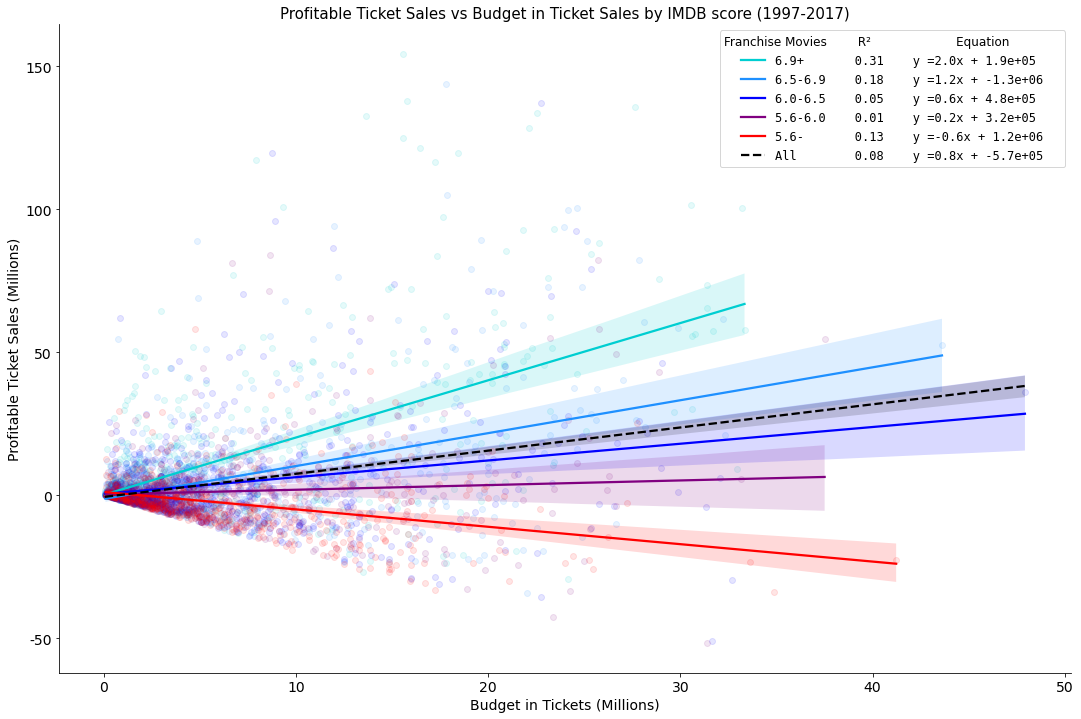

In [46]:
# Revenue vs Budget by Cinemascore
l_stat, r_2, slope_eq = lineplot_groups(
    table = imdb_scoring.sort_values("prof_tickets", ascending = False)[3:],
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "vote_bracket",
    x_lab = 'Budget in Tickets (Millions)',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Ticket Sales vs Budget in Ticket Sales by IMDB score (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['darkturquoise','dodgerblue','blue','purple', 'red']
)

# Legend
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Franchise Movies        R\u00b2                      Equation             ',
           loc='upper right',
           prop={'size': 12, "family":"monospace"},
           labels=['6.9+       {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
                   '6.5-6.9    {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
                   '6.0-6.5    {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
                   '5.6-6.0    {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
                   '5.6-       {}    {}'.format(l_stat[4][0], l_stat[4][1][0]),
                   'All        {}    {}'.format(r_2, slope_eq)
            ]
          )

### Budget

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3321023246.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3321023246.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


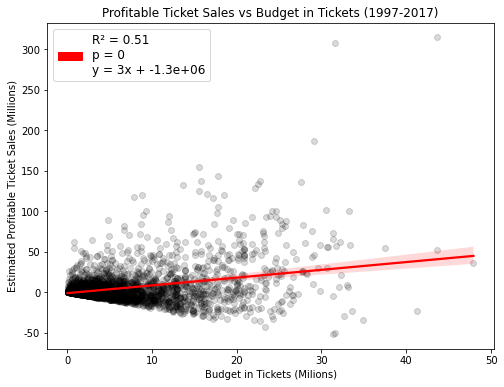

In [47]:
# Estimated Ticket Sales vs Budget
plt.figure(figsize=(8,6))
plt.title("Profitable Ticket Sales vs Budget in Tickets (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="budget_tickets", y="prof_tickets", data=imdb_scoring,
          scatter_kws={'alpha':0.15, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Budget in Tickets (Milions)', ylabel='Estimated Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['budget_tickets'], imdb_scoring['est_tickets'])
ticket_budget_label = 'R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept)
legend_text = mpatches.Patch(color='red', label=ticket_budget_label,)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


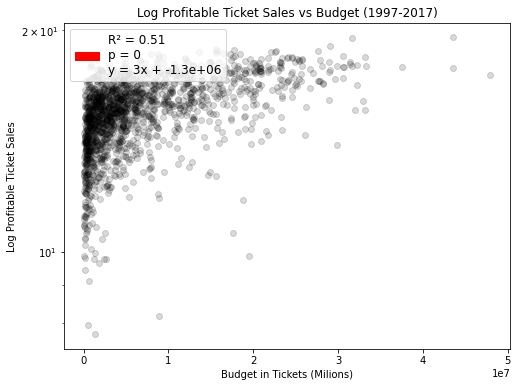

In [48]:
# Switch budget_tickets to log scale
#imdb_scoring['log_budget_tickets'] = np.log(imdb_scoring['budget_tickets'])
imdb_scoring['log_prof_tickets'] = np.log(imdb_scoring['prof_tickets'])

# Estimated Ticket Sales vs Budget
plt.figure(figsize=(8,6))
plt.title("Log Profitable Ticket Sales vs Budget (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="budget_tickets", y="log_prof_tickets", data=imdb_scoring,
          scatter_kws={'alpha':0.15, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Budget in Tickets (Milions)', ylabel='Log Profitable Ticket Sales')
g.set_yscale('log')

# ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
# g.set_yticklabels(ylabels)
# xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['budget_tickets'], imdb_scoring['est_tickets'])
ticket_budget_label = 'R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept)
legend_text = mpatches.Patch(color='red', label=ticket_budget_label,)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

In [49]:
budget_percentiles

array([ 1248049.92199688,  2866682.81458157,  5072479.88533138,
       10413581.87098266])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


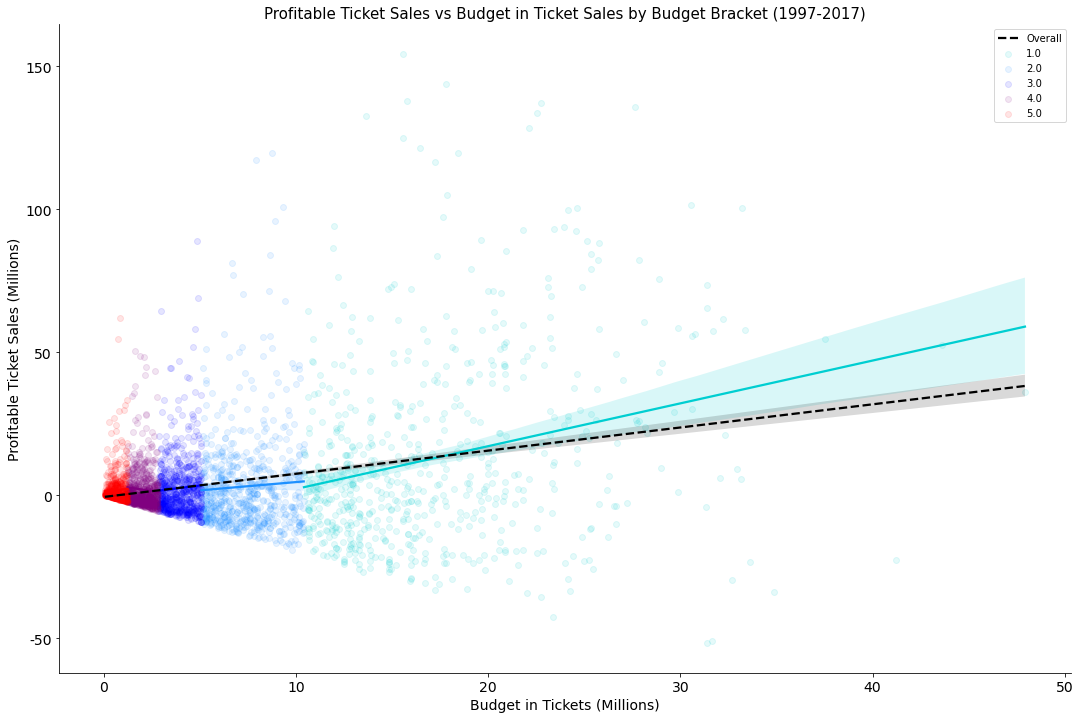

In [51]:
# Revenue vs Budget by Cinemascore
l_stat, r_2, slope_eq = lineplot_groups(
    table = imdb_scoring.sort_values("prof_tickets", ascending = False)[3:],
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "budget_bracket",
    x_lab = 'Budget in Tickets (Millions)',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Ticket Sales vs Budget in Ticket Sales by Budget Bracket (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['darkturquoise','dodgerblue','blue','purple', 'red']
)

plt.legend()

# Legend
# plt.rcParams['legend.title_fontsize'] = '12'
# plt.legend(title='Franchise Movies        R\u00b2                      Equation             ',
#            loc='upper right',
#            prop={'size': 12, "family":"monospace"},
#            labels=['6.9+       {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
#                    '6.5-6.9    {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
#                    '6.0-6.5    {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
#                    '5.6-6.0    {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
#                    '5.6-       {}    {}'.format(l_stat[4][0], l_stat[4][1][0]),
#                    'All        {}    {}'.format(r_2, slope_eq)
#             ]
#           )

In [52]:
imdb_scoring.head(1)

,original_title,title,director,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,budget_bracket,log_prof_tickets
0,The Relic,The Relic,Peter Hyams,1997-01-10,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0,1.0,NaN


In [53]:
budget_percentiles

array([ 1248049.92199688,  2866682.81458157,  5072479.88533138,
       10413581.87098266])

[Text(0, 0, '10.4 or More'),
 Text(1, 0, '10.4 to 5.1'),
 Text(2, 0, '5.1 to 2.8'),
 Text(3, 0, '2.8 to 1.2'),
 Text(4, 0, '1.2 or less')]

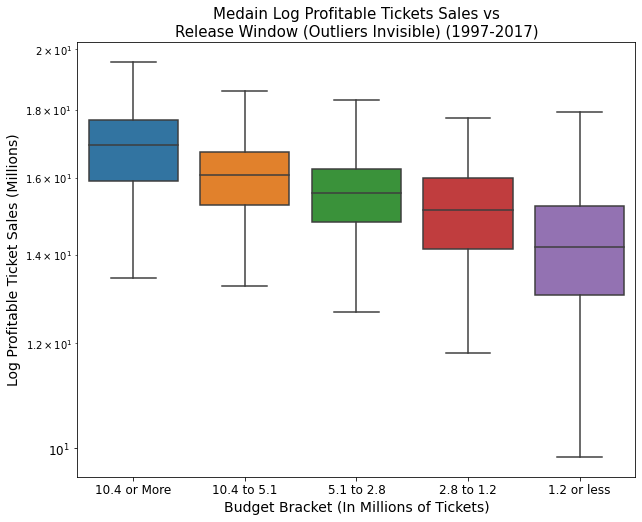

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,8))


sns.boxplot(x="budget_bracket", y="log_prof_tickets",
            data=imdb_scoring,
            #order=plot_order['release_month'],
            ax = ax,
            showfliers = False, # hides outliers
            #showmeans=True
           )

ax.set_title('Medain Log Profitable Tickets Sales vs\nRelease Window (Outliers Invisible) (1997-2017)',
             fontsize= 15)
plt.xlabel('Budget Bracket (In Millions of Tickets)', fontsize=14)
plt.ylabel('Log Profitable Ticket Sales (Millions)', fontsize=14)

# for item in ax.get_xticklabels():
#     item.set_rotation(45)

#ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()/1e6]
#ax.set_yticklabels(ylabels)

ax.set_yscale('log')

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.set_xticklabels(['10.4 or More','10.4 to 5.1', '5.1 to 2.8','2.8 to 1.2','1.2 or less'])



# Add line to represent profitability
#ax.axhline(0.0, color = 'red', linewidth=1, linestyle='--' ,label = "Presumed Profitability")

In [55]:
imdb_scoring[imdb_scoring['budget_bracket'] == 1]['returns_ratio'].mean()

0.7054650766987037

[Text(0, 0, '10.4 or More'),
 Text(1, 0, '10.4 to 5.1'),
 Text(2, 0, '5.1 to 2.8'),
 Text(3, 0, '2.8 to 1.2'),
 Text(4, 0, '1.2 or less')]

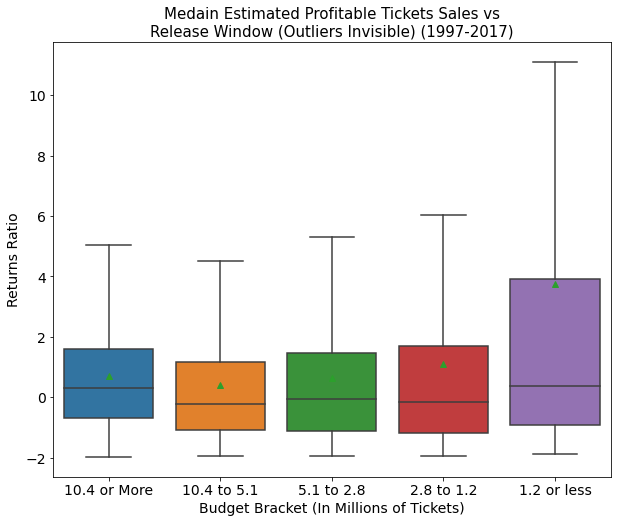

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.boxplot(x="budget_bracket", y="returns_ratio", data=imdb_scoring,
                         #order=plot_order['release_month'],
                         ax = ax,
                         showfliers = False, # hides outliers
                         showmeans=True)

ax.set_title('Medain Estimated Profitable Tickets Sales vs\nRelease Window (Outliers Invisible) (1997-2017)',
             fontsize= 15)
plt.xlabel('Budget Bracket (In Millions of Tickets)', fontsize=14)
plt.ylabel('Returns Ratio', fontsize=14)

# for item in ax.get_xticklabels():
#     item.set_rotation(45)
#ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()1e6]
#ax.set_yticklabels(ylabels)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_xticklabels(['10.4 or More','10.4 to 5.1', '5.1 to 2.8','2.8 to 1.2','1.2 or less'])

In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


model = ols('returns_ratio ~ C(budget_bracket)', data=imdb_scoring[imdb_scoring['budget_bracket'] < 5]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(budget_bracket),154.642235,3.0,6.602541,0.000192
Residual,20665.680628,2647.0,NaN,NaN


Low p value therefore not all the same

#### Number of franchise movies

[Text(0.5, 0, 'Num Franchise Films'),
 Text(0.5, 1.0, 'Num Franchise Movies Distribution')]

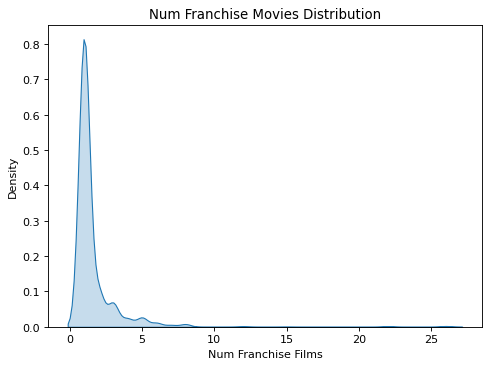

In [59]:
figure(figsize=(7, 5), dpi=80)
#g = sns.histplot(data=cinemascore_only, x="cinemascore_num", kde = True)
g = sns.kdeplot(data=imdb_scoring, x="num_franchies_movies", shade = True)

c_25 = imdb_scoring['num_franchies_movies'].quantile(0.25)
c_50 = imdb_scoring['num_franchies_movies'].quantile(0.50)
c_75 = imdb_scoring['num_franchies_movies'].quantile(0.75)

# plt.axvline(c_25, color='r')
# plt.axvline(c_50, color='r')
# plt.axvline(c_75, color='r')

g.set(xlabel='Num Franchise Films', title = "Num Franchise Movies Distribution")

#g.set_xticklabels(['F','D','C-','C+','B', 'A-', 'A+'])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1027976691.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


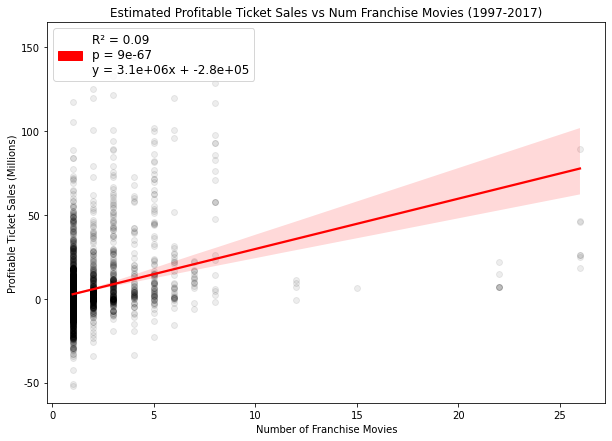

In [60]:
plt.figure(figsize=(10,7))
plt.title("Estimated Profitable Ticket Sales vs Num Franchise Movies (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="num_franchies_movies", y="prof_tickets",
                data=imdb_scoring.sort_values("prof_tickets", ascending = False)[3:],
          scatter_kws={'alpha':0.07, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Number of Franchise Movies', ylabel='Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['num_franchies_movies'], imdb_scoring['prof_tickets'])
legend_text = mpatches.Patch(color='red', label='R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

In [61]:
imdb_scoring['franchise_bracket'] = imdb_scoring['num_franchies_movies']  
#imdb_scoring.loc[imdb_scoring.num_franchies_movies >= 6, 'franchise_bracket'] = 6

for i in range(len(imdb_scoring)):
    if imdb_scoring['franchise_bracket'][i] <= 1:
        imdb_scoring['franchise_bracket'][i] = "single_film"
    elif imdb_scoring['franchise_bracket'][i] == 2:
        imdb_scoring['franchise_bracket'][i] = "duology"
    elif imdb_scoring['franchise_bracket'][i] == 3:
        imdb_scoring['franchise_bracket'][i] = "trilogy"
    elif imdb_scoring['franchise_bracket'][i] == 4:
        imdb_scoring['franchise_bracket'][i] = "tetralogy"
    elif imdb_scoring['franchise_bracket'][i] == 5:
        imdb_scoring['franchise_bracket'][i] = "pentalogy"
    else:
        imdb_scoring['franchise_bracket'][i] = "6+ movies"

imdb_scoring.franchise_bracket = pd.Categorical(imdb_scoring.franchise_bracket, 
                      categories=["single_film","duology","trilogy","tetralogy", "pentalogy", "6+ movies"],
                      ordered=True)

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


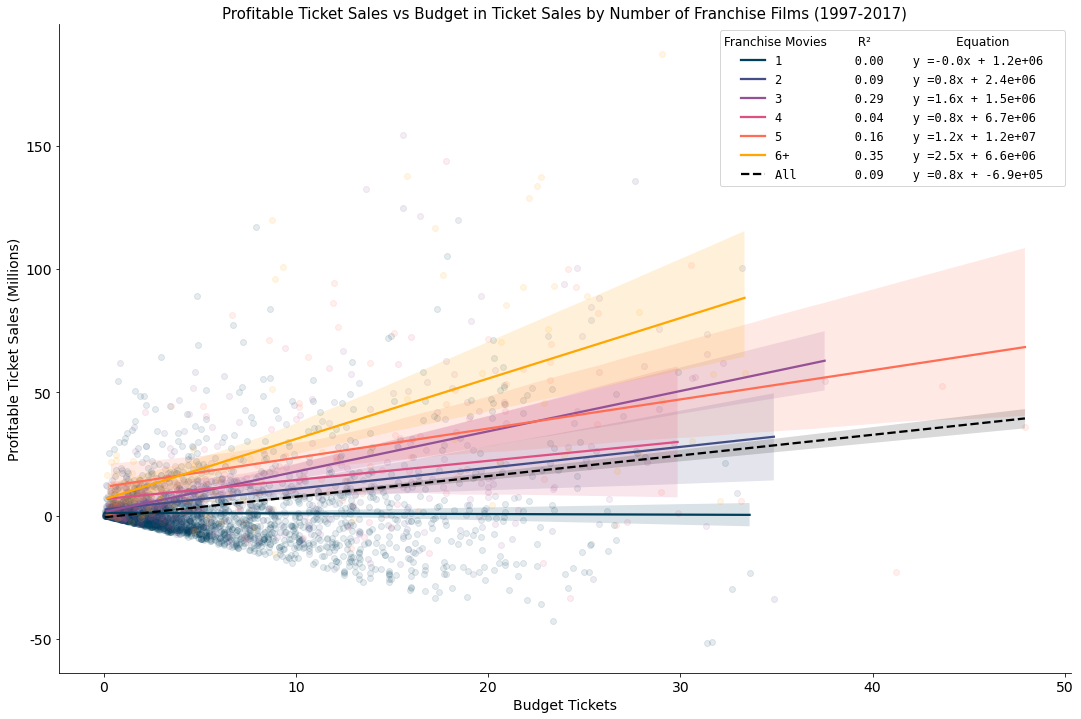

In [62]:
# Revenue vs Budget by Num Franchise Movies

l_stat, r_2, slope_eq = lineplot_groups(
    table = imdb_scoring.sort_values("prof_tickets", ascending = False)[2:],
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "franchise_bracket",
    x_lab = 'Budget Tickets',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Ticket Sales vs Budget in Ticket Sales by Number of Franchise Films (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54', '#ffa600']
)

plt.legend()
    
# Legend
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Franchise Movies        R\u00b2                      Equation             ',
           loc='upper right',
           prop={'size': 12, "family":"monospace"},
           labels=['1          {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
                   '2          {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
                   '3          {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
                   '4          {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
                   '5          {}    {}'.format(l_stat[4][0], l_stat[4][1][0]),
                   '6+         {}    {}'.format(l_stat[5][0], l_stat[5][1][0]),
                   'All        {}    {}'.format(r_2, slope_eq)
            ]
          )


#### Looking at different genres

In [63]:
genre_scoring = imdb_scoring.copy(deep = True)
genre_scoring = genre_scoring[['title', 'imdb_id', 'revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets', 'genres']]

genre_scoring['genre_only'] = np.empty((len(genre_scoring), 0)).tolist()

index_i = 0
for i in genre_scoring['genres']:
    for j in i:
        genre_scoring['genre_only'][index_i].append(j['name'])
    index_i = index_i + 1

genre_scoring = genre_scoring.drop("genres", axis = 1)

genre_scoring = genre_scoring.set_index(['title','imdb_id','revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets'])['genre_only'].apply(pd.Series).stack()
genre_scoring = genre_scoring.reset_index()
genre_scoring.columns = ['title','imdb_id','revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets', 'genre_num','genre_only']

In [64]:
genre_scoring['genre_only'].value_counts()

Drama              1531
Comedy             1190
Thriller            960
Action              932
Adventure           634
Romance             597
Crime               529
Science Fiction     394
Family              380
Fantasy             337
Horror              316
Mystery             285
Animation           230
History             132
War                 108
Music                95
Western              32
Documentary          25
Foreign              16
Name: genre_only, dtype: int64

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2860084294.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2860084294.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


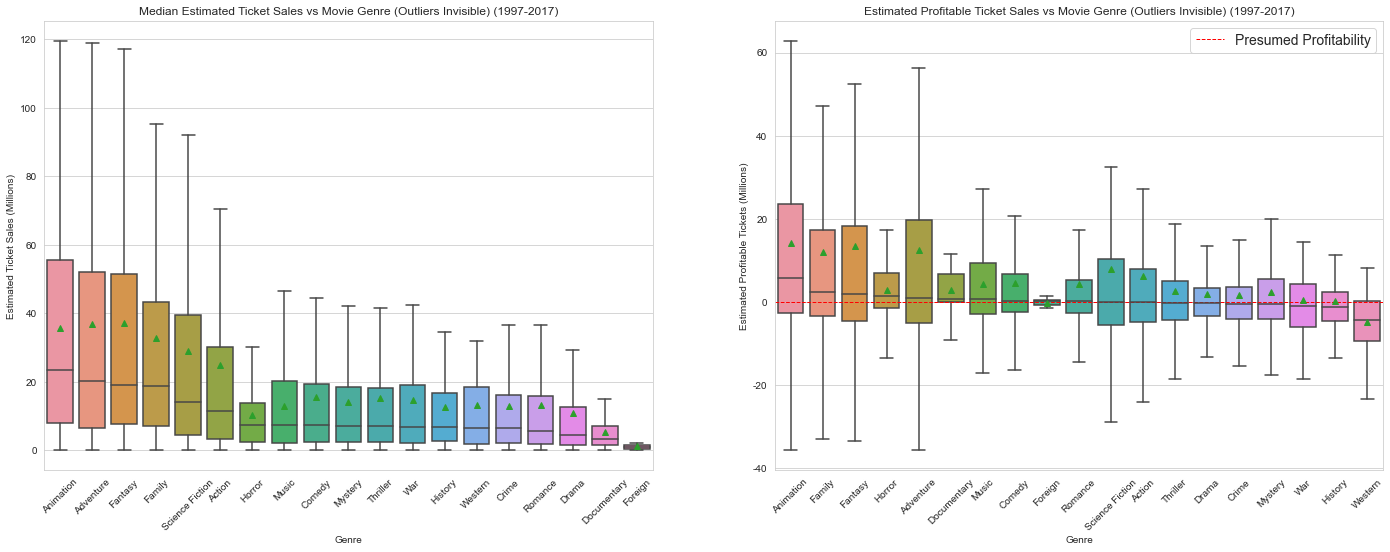

In [185]:
fig, ax = plt.subplots(1,2, figsize=(24,8.27))
sns.set_style("whitegrid")

# Plot ticket sales
plot_order = genre_scoring.groupby(["genre_only"])['est_tickets'].aggregate(np.median).reset_index().sort_values('est_tickets', ascending = False)
sns.boxplot(x="genre_only", y="est_tickets", data=genre_scoring,
                         order=plot_order['genre_only'],
                         #estimator=median,
                         ax = ax[0],
                         showfliers = False, # hides outliers
                         showmeans=True)

ax[0].title.set_text('Median Estimated Ticket Sales vs Movie Genre (Outliers Invisible) (1997-2017)')

ax[0].set(xlabel="Genre", ylabel="Estimated Ticket Sales (Millions)")
for item in ax[0].get_xticklabels():
    item.set_rotation(45)

ylabels = ['{:,.0f}'.format(x) for x in ax[0].get_yticks()/1e6]
ax[0].set_yticklabels(ylabels)

    
# Plot Number of Profitable tickets
plot_order = genre_scoring.groupby(["genre_only"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="genre_only", y="prof_tickets", data=genre_scoring,
                         order=plot_order['genre_only'],
                         showfliers = False, # hides outliers
                         ax = ax[1],
                         showmeans=True)
ax[1].title.set_text('Estimated Profitable Ticket Sales vs Movie Genre (Outliers Invisible) (1997-2017)', )
ax[1].set(xlabel="Genre", ylabel="Estimated Profitable Tickets (Millions)")
for item in ax[1].get_xticklabels():
    item.set_rotation(45)

ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)

#ax[1].set_yticks([-1, 1, 3, 5, 7, 9, 11, 13])

# Add line to represent profitability
ax[1].axhline(0.0, color = 'red', linewidth=1, linestyle='--' ,label = "Presumed Profitability")
ax[1].legend(fontsize = 14)

## Seasonal release windows

In [66]:
def switcher_month(argument):
    switcher = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
    return switcher.get(argument, "Invalid month")

# Yearly Windows were decided based on the average proportion of yearly sales for each month
def switcher_window(argument):
    switcher = {
        1: "New Year",
        2: "New Year",
        3: "New Year",
        4: "New Year",
        5: "Summer",
        6: "Summer",
        7: "Summer",
        8: "Fall",
        9: "Fall",
        10: "Fall",
        11: "Holiday",
        12: "Holiday"
    }
    return switcher.get(argument, "Invalid month")

In [67]:
imdb_scoring['release_window'] = np.NaN
imdb_scoring['release_month'] = np.NaN
imdb_scoring['release_year'] = np.NaN

for i in range(len(imdb_scoring['release_date'])):
    imdb_scoring['release_window'][i] = switcher_window(imdb_scoring['release_date'][i].month)
    imdb_scoring['release_month'][i] = switcher_month(imdb_scoring['release_date'][i].month)
    imdb_scoring['release_year'][i] = imdb_scoring['release_date'][i].year

In [68]:
# Calculate what proportion of yearly sales each month made up

# prepare dataframe to store values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

years = []
for i in range(1997, 2017):
    for j in range(12):
        years.append(i)


sales_by_month = pd.DataFrame(columns=['month','year', 'prop_yearly_sales'])
sales_by_month.month = months * 20
sales_by_month.year = years

# Fill dataframe with values
for i in range(len(sales_by_month)):
    matching_movies = (imdb_scoring['release_month'] == sales_by_month['month'][i]) & (imdb_scoring['release_year']==sales_by_month['year'][i])
    
    sales_by_month['prop_yearly_sales'][i] = (
        sum(imdb_scoring[matching_movies]['revenue']) /
        sum(imdb_scoring['revenue'][imdb_scoring['release_year']==sales_by_month['year'][i]])
    )

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3555109131.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


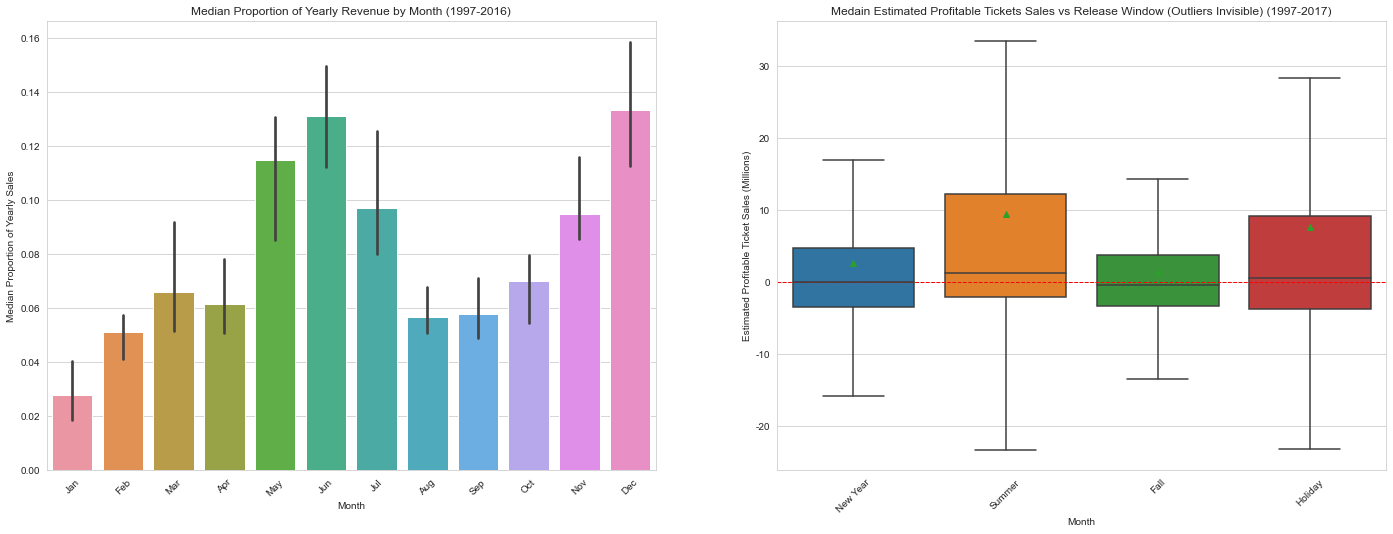

In [69]:
fig, ax = plt.subplots(1,2, figsize=(24,8.27))
sns.set_style("whitegrid")

# Plot Each Month's Average Proporiton of Yearly Sales 
sns.barplot(x="month", y="prop_yearly_sales", data=sales_by_month,
                         #order=plot_order['month'],
                         estimator=median,
                         ax = ax[0])

ax[0].title.set_text('Median Proportion of Yearly Revenue by Month (1997-2016)')

ax[0].set(xlabel="Month", ylabel="Median Proportion of Yearly Sales")
for item in ax[0].get_xticklabels():
    item.set_rotation(45)

    
sns.boxplot(x="release_window", y="prof_tickets", data=imdb_scoring,
                         #order=plot_order['release_month'],
                         ax = ax[1],
                         showfliers = False, # hides outliers
                         showmeans=True)
ax[1].title.set_text('Medain Estimated Profitable Tickets Sales vs Release Window (Outliers Invisible) (1997-2017)', )
ax[1].set(xlabel="Month", ylabel="Estimated Profitable Ticket Sales (Millions)")

for item in ax[1].get_xticklabels():
    item.set_rotation(45)
ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)

# Add line to represent profitability
ax[1].axhline(0.0, color = 'red', linewidth=1, linestyle='--' ,label = "Presumed Profitability")

In [70]:
model = ols('prof_tickets ~ C(release_window)', data=imdb_scoring).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(release_window),3.696584e+16,3.0,31.463369,4.767188e-20
Residual,1.295898e+18,3309.0,NaN,NaN


/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


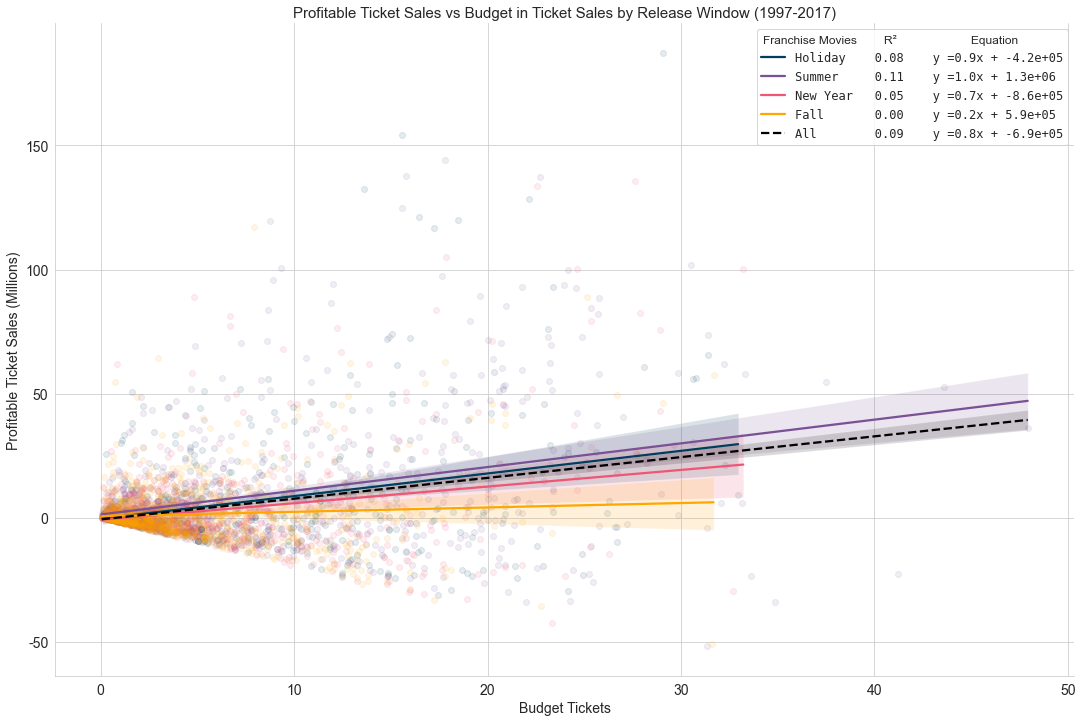

In [71]:
# Revenue vs Budget by Genre

l_stat, r_2, slope_eq = lineplot_groups(
    table = imdb_scoring.sort_values("prof_tickets", ascending = False)[2:],
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "release_window",
    x_lab = 'Budget Tickets',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Ticket Sales vs Budget in Ticket Sales by Release Window (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
)

#plt.legend()
    
# Legend
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Franchise Movies        R\u00b2                      Equation             ',
           loc='upper right',
           prop={'size': 12, "family":"monospace"},
           labels=['Holiday    {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
                   'Summer     {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
                   'New Year   {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
                   'Fall       {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
                   'All        {}    {}'.format(r_2, slope_eq)
            ]
          )

#### Examining Runtime

[Text(0.5, 0, 'Movie Runtime'), Text(0.5, 1.0, 'Film Runtime Distribution')]

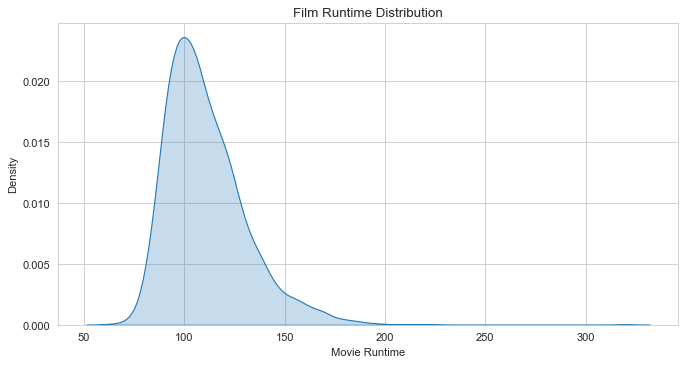

In [72]:
figure(figsize=(10, 5), dpi=80)
#g = sns.histplot(data=cinemascore_only, x="cinemascore_num", kde = True)
g = sns.kdeplot(data=imdb_scoring, x="runtime", shade = True)

c_25 = imdb_scoring['runtime'].quantile(0.25)
c_50 = imdb_scoring['runtime'].quantile(0.50)
c_75 = imdb_scoring['runtime'].quantile(0.75)

# plt.axvline(c_25, color='r')
# plt.axvline(c_50, color='r')
# plt.axvline(c_75, color='r')

g.set(xlabel='Movie Runtime', title = "Film Runtime Distribution")

#g.set_xticklabels(['F','D','C-','C+','B', 'A-', 'A+'])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2307500549.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2307500549.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


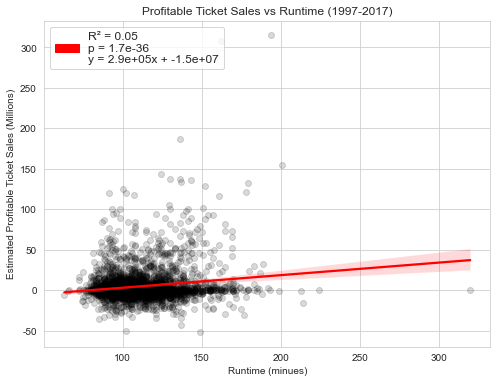

In [73]:
# Revenue vs Runtime
plt.figure(figsize=(8,6))
plt.title("Profitable Ticket Sales vs Runtime (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="runtime", y="prof_tickets", data=imdb_scoring,
          scatter_kws={'alpha':0.15, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Runtime (minues)', ylabel='Estimated Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['runtime'], imdb_scoring['est_tickets'])
ticket_budget_label = 'R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept)
legend_text = mpatches.Patch(color='red', label=ticket_budget_label,)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

In [74]:
imdb_scoring['runtime_bracket'] = np.nan

run_percentiles = percentile(imdb_scoring['runtime'], [20, 40, 60, 80])

for i in range(len(imdb_scoring)):
    if imdb_scoring['runtime'][i] >= run_percentiles[3]:
        imdb_scoring['runtime_bracket'][i] = "125+ mins"
    elif imdb_scoring['runtime'][i] >= run_percentiles[2]:
        imdb_scoring['runtime_bracket'][i] = "112-124 mins"
    elif imdb_scoring['runtime'][i] >= run_percentiles[1]:
        imdb_scoring['runtime_bracket'][i] = "103-111 mins"
    elif imdb_scoring['runtime'][i] >= run_percentiles[0]:
        imdb_scoring['runtime_bracket'][i] = "94-102 mins"
    else:
        imdb_scoring['runtime_bracket'][i] = "93- mins"
        
imdb_scoring.runtime_bracket = pd.Categorical(imdb_scoring.runtime_bracket, 
                      categories=["125+ mins","112-124 mins","103-111 mins","94-102 mins", "93- mins"],
                      ordered=True)

In [75]:
run_percentiles

array([ 94., 103., 112., 125.])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=14)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3251887004.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=14)


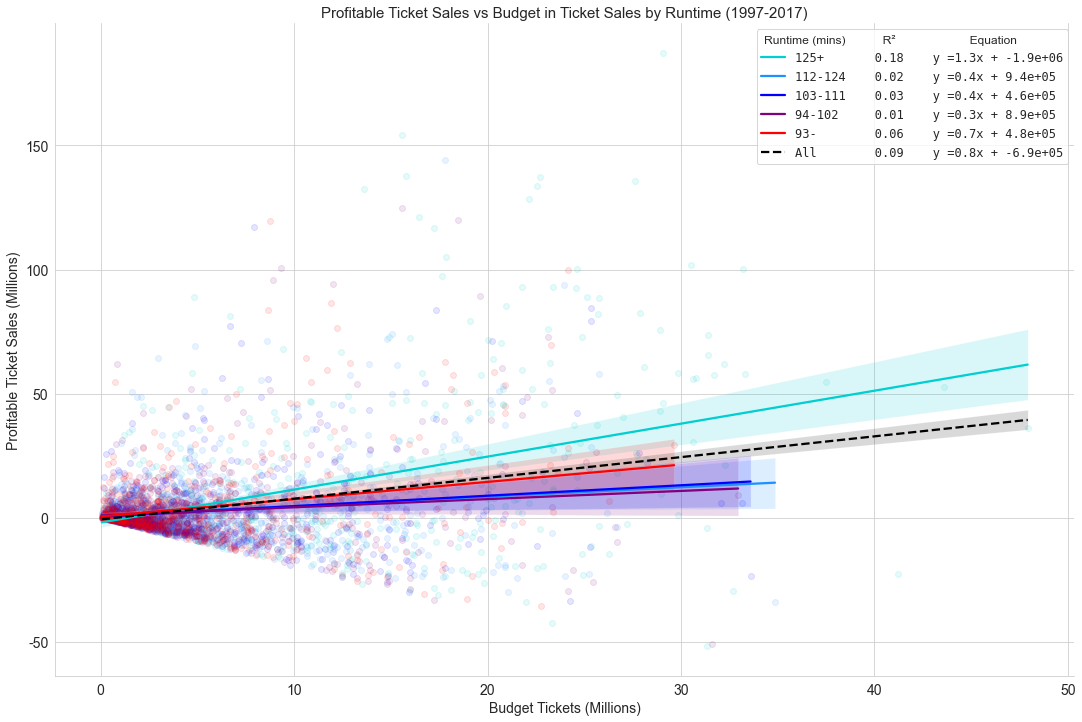

In [76]:
# Revenue vs Budget by Genre

l_stat, r_2, slope_eq = lineplot_groups(
    table = imdb_scoring.sort_values("prof_tickets", ascending = False)[2:].sort_values('runtime_bracket'),
    x = "budget_tickets",
    y = "prof_tickets",
    hue = "runtime_bracket",
    x_lab = 'Budget Tickets (Millions)',
    y_lab = 'Profitable Ticket Sales (Millions)',
    title = "Profitable Ticket Sales vs Budget in Ticket Sales by Runtime (1997-2017)",
    x_scale = 1e6,
    y_scale = 1e6,
    palette = ['darkturquoise','dodgerblue','blue','purple', 'red']
)

#plt.legend()
    
# Legend
plt.rcParams['legend.title_fontsize'] = '12'
plt.legend(title='Runtime (mins)           R\u00b2                      Equation             ',
           loc='upper right',
           prop={'size': 12, "family":"monospace"},
           labels=['125+       {}    {}'.format(l_stat[0][0], l_stat[0][1][0]),
                   '112-124    {}    {}'.format(l_stat[1][0], l_stat[1][1][0]),
                   '103-111    {}    {}'.format(l_stat[2][0], l_stat[2][1][0]),
                   '94-102     {}    {}'.format(l_stat[3][0], l_stat[3][1][0]),
                   '93-        {}    {}'.format(l_stat[4][0], l_stat[4][1][0]),
                   'All        {}    {}'.format(r_2, slope_eq)
            ]
          )

#### Examining Production Companies

In [77]:
production_scoring = imdb_scoring.copy(deep = True)
production_scoring = production_scoring[['title', 'imdb_id', 'revenue', 'budget', 'budget_tickets', 'est_tickets', 'prof_tickets', 'production_companies']]

production_scoring['production_company'] = np.empty((len(production_scoring), 0)).tolist()

index_i = 0
for i in production_scoring['production_companies']:
    for j in i:
        production_scoring['production_company'][index_i].append(j['name'])
    index_i = index_i + 1

production_scoring = production_scoring.drop("production_companies", axis = 1)

production_scoring = production_scoring.set_index(['title','imdb_id','revenue', 'budget', 'budget_tickets', 'est_tickets', 'prof_tickets'])['production_company'].apply(pd.Series).stack()
production_scoring = production_scoring.reset_index()
production_scoring.columns = ['title','imdb_id','revenue', 'budget', 'budget_tickets', 'est_tickets', 'prof_tickets', 'studio_num','production_company']

In [78]:
studio_counts = pd.DataFrame(production_scoring['production_company'].value_counts()).reset_index()
studio_counts = studio_counts.rename(columns={"index": "production_company", "production_company": "num_movies"})
studio_means = production_scoring.groupby('production_company').mean()

studio_means = studio_means.merge(studio_counts, how = 'inner', on = ['production_company', 'production_company'])
studio_means_3_up = studio_means[studio_means['num_movies'] >= 3]

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2214375520.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/2214375520.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


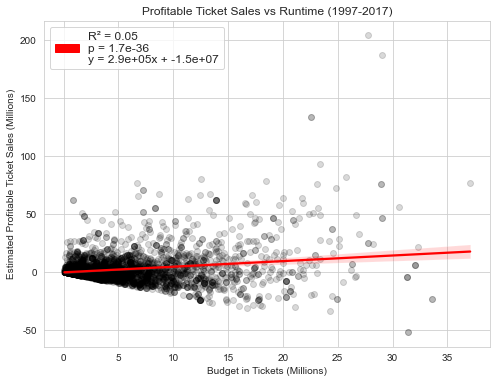

In [79]:
# Revenue vs Runtime
plt.figure(figsize=(8,6))
plt.title("Profitable Ticket Sales vs Runtime (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="budget_tickets", y="prof_tickets",
                data=studio_means,
                scatter_kws={'alpha':0.15, "color": "black"},
                line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Budget in Tickets (Millions)', ylabel='Estimated Profitable Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['runtime'], imdb_scoring['est_tickets'])
ticket_budget_label = 'R\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept)
legend_text = mpatches.Patch(color='red', label=ticket_budget_label,)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

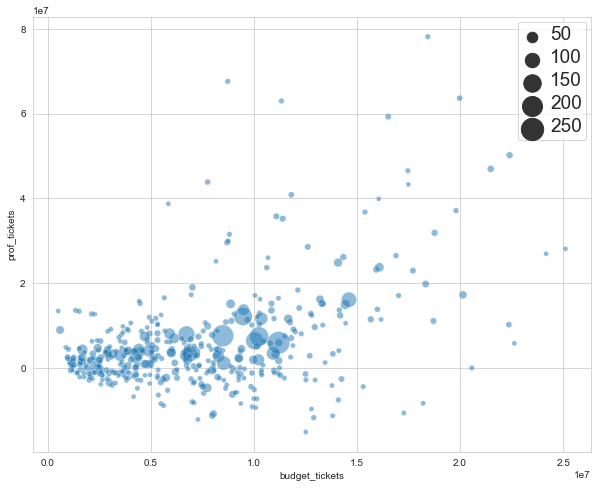

In [80]:
# Profitable tickets vs budget tickets by studio with size scaling by studio 
plt.figure(figsize=(10,8))

ax = sns.scatterplot(data = studio_means[studio_means['num_movies'] >= 5],
                size = 'num_movies',
                x = "budget_tickets",
                y = "prof_tickets",
                alpha=.5,
                sizes = (25,500)
               )

plt.legend(loc='best',markerscale=1)
plt.setp(ax.get_legend().get_texts(), fontsize='19') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title


plt.show()

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1764633966.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1764633966.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


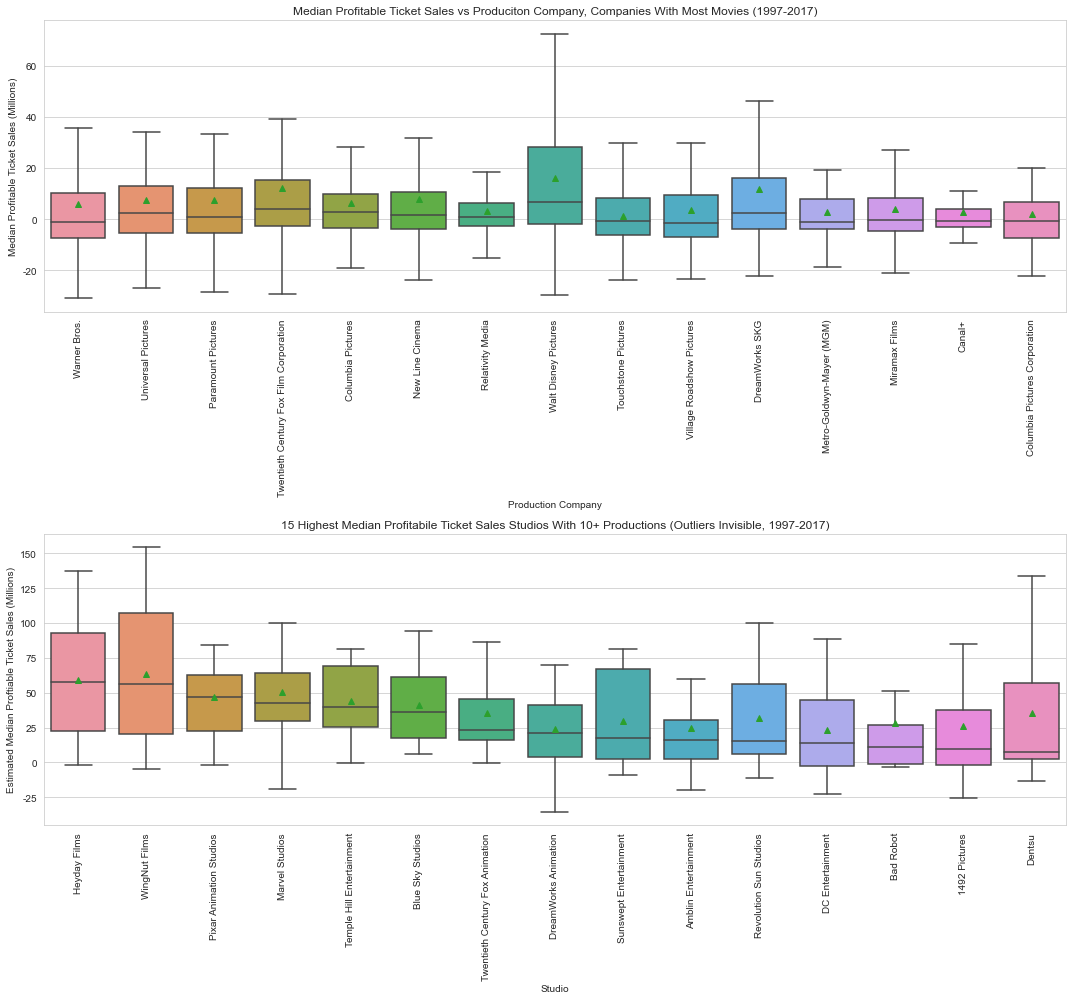

In [81]:
fig, ax = plt.subplots(2,1, figsize=(15,14))
sns.set_style("whitegrid")


biggest_stuidos = list(production_scoring['production_company'].value_counts().head(15)[:].index)
production_scoring_biggest = production_scoring[production_scoring['production_company'].isin(biggest_stuidos)]

# Plot ticket sales
plot_order = production_scoring_biggest.groupby(["production_company"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="production_company", y="prof_tickets", data=production_scoring_biggest,
                         order=biggest_stuidos,
                         #estimator=median,
                         ax = ax[0],
                         showfliers = False,
                         showmeans=True)

ax[0].title.set_text('Median Profitable Ticket Sales vs Produciton Company, Companies With Most Movies (1997-2017)')

ax[0].set(xlabel="Production Company", ylabel="Median Profitable Ticket Sales (Millions)")
for item in ax[0].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[0].get_yticks()/1e6]
ax[0].set_yticklabels(ylabels)

    
#Plot returns ratio
# return_ratio_genre = genre_scoring.copy(deep = True)
# return_ratio_genre['returns_ratio'] = return_ratio_genre['returns_ratio'] - 1.0

most_profitable_studios = list(studio_means[studio_means['num_movies'] >= 10].sort_values('prof_tickets', ascending = False).head(15)['production_company'])
production_scoring_best = production_scoring[production_scoring['production_company'].isin(most_profitable_studios)]

plot_order = production_scoring_best.groupby(["production_company"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="production_company", y="prof_tickets", data=production_scoring_best,
                         order=plot_order['production_company'],
                         showfliers = False, # hides outliers
                         ax = ax[1],
                         showmeans=True)
ax[1].title.set_text('15 Highest Median Profitabile Ticket Sales Studios With 10+ Productions (Outliers Invisible, 1997-2017)', )
ax[1].set(xlabel="Studio", ylabel="Estimated Median Proftiable Ticket Sales (Millions)")
for item in ax[1].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)
# ax[1].axhline(1.00, color = 'red', label = "Presumed Profitability")
# ax[1].legend(fontsize = 14)

fig.tight_layout()

#### Director

In [82]:
imdb_scoring.head(1)

,original_title,title,director,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,budget_bracket,log_prof_tickets,franchise_bracket,release_window,release_month,release_year,runtime_bracket
0,The Relic,The Relic,Peter Hyams,1997-01-10,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0,1.0,NaN,single_film,New Year,Jan,1997.0,103-111 mins


/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1355376236.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/1355376236.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


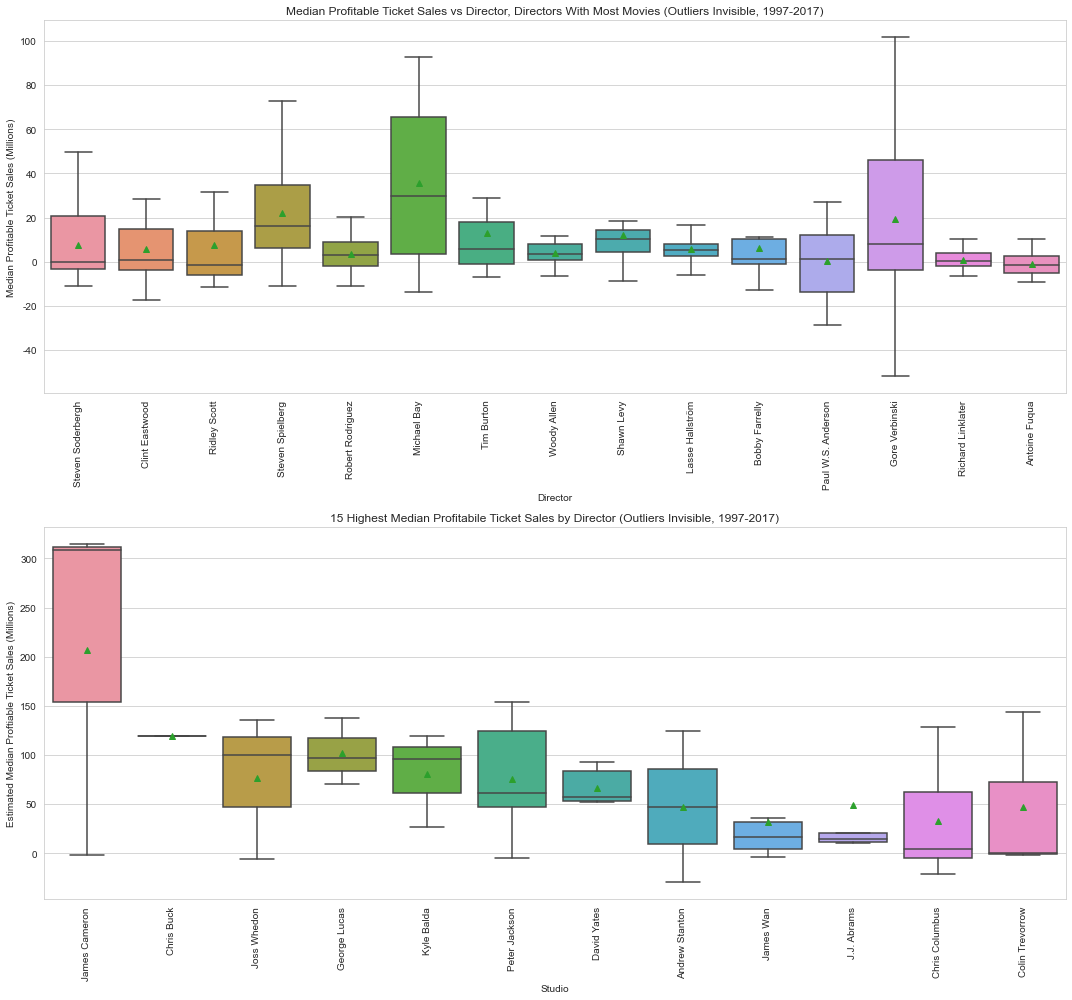

In [83]:
fig, ax = plt.subplots(2,1, figsize=(15,14))
sns.set_style("whitegrid")


biggest_directors = list(imdb_scoring['director'].value_counts().head(15)[:].index)
director_scoring_biggest = imdb_scoring[imdb_scoring['director'].isin(biggest_directors)]

# Plot ticket sales
plot_order = director_scoring_biggest.groupby(["director"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="director", y="prof_tickets", data=imdb_scoring,
                         order=biggest_directors,
                         #estimator=median,
                         ax = ax[0],
                         showfliers = False,
                         showmeans=True)

ax[0].title.set_text('Median Profitable Ticket Sales vs Director, Directors With Most Movies (Outliers Invisible, 1997-2017)')

ax[0].set(xlabel="Director", ylabel="Median Profitable Ticket Sales (Millions)")
for item in ax[0].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[0].get_yticks()/1e6]
ax[0].set_yticklabels(ylabels)




most_profitable_directors = list(imdb_scoring.sort_values('prof_tickets', ascending = False).head(15)['director'])
director_scoring_best = imdb_scoring[imdb_scoring['director'].isin(most_profitable_directors)]

plot_order = director_scoring_best.groupby(["director"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="director", y="prof_tickets", data=imdb_scoring,
                         order=plot_order['director'],
                         showfliers = False, # hides outliers
                         ax = ax[1],
                         showmeans=True)
ax[1].title.set_text('15 Highest Median Profitabile Ticket Sales by Director (Outliers Invisible, 1997-2017)', )
ax[1].set(xlabel="Studio", ylabel="Estimated Median Proftiable Ticket Sales (Millions)")
for item in ax[1].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)
# ax[1].axhline(1.00, color = 'red', label = "Presumed Profitability")
# ax[1].legend(fontsize = 14)



fig.tight_layout()

## Building a Linear Model

#### Create Dataframe For Linear Model

In [85]:
# Attach scores from earlier dataframes
model_movies = imdb_scoring.sort_values("prof_tickets", ascending = False)[2:].copy(deep = True)
c_rank = cinemascore_only.drop(cinemascore_only.columns.difference(['imdb_id', 'cinemascore_rank']), axis = 1)

model_movies = pd.merge(left=model_movies, right=c_rank, left_on='imdb_id', right_on='imdb_id', how='left')

# CORRECTING VALUES IN COLUMNS

# Need to invert ranks to make 5 the best and 1 the worst to work in a linear model
def switcher_invert_ranks(argument):
    switcher = {
        1: 5,
        2: 4,
        3: 3,
        4: 2,
        5: 1,
    }
    return switcher.get(argument, None)

for i in range(len(model_movies)):
    model_movies['cinemascore_rank'][i] = switcher_invert_ranks(model_movies['cinemascore_rank'][i])
    model_movies['vote_bracket'][i] = switcher_invert_ranks(model_movies['vote_bracket'][i])

# Simple imputation calculation to replace NaN Cinemascore values with the mean
model_movies['cinemascore_rank'] = model_movies['cinemascore_rank'].fillna(model_movies['cinemascore_rank'].mean())

# Switch budget_tickets to log scale
model_movies['log_budget_tickets'] = np.log(model_movies['budget_tickets'])

# Make dictionaries into lists
#Make translator to remove punctuation
exclist = string.punctuation + '/'
translator = str.maketrans(exclist, ' '*len(exclist))

def str_from_dict(table, column, pref):
    i_loc = 0
    
    for i in table[column]:
        if type(i) is list:
            studios = ""
            for j in i:
                 #studios.append(j['name'])
                og_str = j['name']
                new_str = og_str.translate(translator) # Remove punctuation
                stu = pref+ str(new_str.replace(" ", "_"))
                studios = studios + stu + " "
            table[column][i_loc] = studios.strip().lower()
    
        else:
            table[column][i_loc] = ""
        i_loc += 1

str_from_dict(model_movies, "production_companies", "pc_")
str_from_dict(model_movies, "genres", "gn_")
str_from_dict(model_movies, "production_countries", "cn_")

model_movies["director"] = "dir_" + model_movies["director"].str.lower().str.replace(' ','_')
model_movies["director"] = model_movies["director"].str.replace('.', '').str.replace("'", "").str.replace("-", "_")
model_movies["director"] = model_movies["director"].str.replace('(', '').str.replace(")", "").str.replace(",", "")

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3242821633.py:58: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  model_movies["director"] = model_movies["director"].str.replace('.', '').str.replace("'", "").str.replace("-", "_")
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3242821633.py:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  model_movies["director"] = model_movies["director"].str.replace('(', '').str.replace(")", "").str.replace(",", "")


In [86]:
# Get list of unproven studios
unproven_studios = list(map(str.lower, list(studio_means[studio_means['num_movies'] < 10]['production_company'])))
unproven_studios = [s.translate(translator) for s in unproven_studios]
unproven_studios = ["pc_" + s.replace(' ', '_') for s in unproven_studios]

# Replace studios with less than 10 movies with "unproven_studio"
for i in range(len(model_movies)):
    s =' '.join("pc_unproven_studio" if i in unproven_studios else i for i in model_movies['production_companies'][i].split())
    words = s.split() # remove repeating "unknown_studio"'s
    new_s =" ".join(sorted(set(words), key=words.index))
    model_movies['production_companies'][i] = new_s

In [87]:
model_movies.head(1)

,original_title,title,director,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,budget_bracket,log_prof_tickets,franchise_bracket,release_window,release_month,release_year,runtime_bracket,cinemascore_rank,log_budget_tickets
0,Star Wars: The Force Awakens,Star Wars: The Force Awakens,dir_jj_abrams,2015-12-15,2.068224e+09,2.138931e+09,245000000.0,2.533759e+08,1.578224e+09,1.632179e+09,6.441729,2.453409e+08,2.906287e+07,1.872151e+08,7993.0,7.5,NaN,NaN,gn_action gn_adventure gn_science_fiction gn_f...,136.0,"{'id': 10, 'name': 'Star Wars Collection', 'po...",8,en,"[{'iso_639_1': 'en', 'name': 'English'}]",cn_united_states_of_america,pc_unproven_studio pc_bad_robot,Thirty years after defeating the Galactic Empi...,-0.886,Every generation has a story.,Released,31.626013,140607,tt2488496,http://www.starwars.com/films/star-wars-episod...,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg,5.0,1.0,19.047769,6+ movies,Holiday,Dec,2015.0,125+ mins,2.791667,17.184972


In [142]:
# Drop Unwanted Columns
movie_drops = model_movies.drop(columns = ['original_title', 'title', 'release_date',
                                           'revenue', 'revenue_adjusted', 'budget', 'budget_adjusted',
                                           'est_profit', 'est_profit_adjusted', 'returns_ratio',
                                           'cinemascore', 'cinemascore_num', 'vote_average', 'belongs_to_collection',
                                           'spoken_languages', 'overview', 'vote_count',
                                           'overview_sentiment', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 
                                           'homepage', 'poster_path', 'runtime', 
                                           'budget_tickets', 'num_franchies_movies', 'budget_bracket',
                                           'log_prof_tickets', 'release_month', 'release_year'
                                          ])

#movie_drops = movie_drops.drop(columns = 'prof_tickets')
movie_drops = movie_drops.drop(columns = 'est_tickets')

# Correct incorrect data types
movie_drops['vote_bracket'] = movie_drops['vote_bracket'].astype('int')
#movie_drops['vote_count'] = movie_drops['vote_count'].astype('int')
#movie_drops['runtime'] = movie_drops['runtime'].astype('int')
movie_drops['original_language'] = movie_drops['original_language'].astype('str')
movie_drops['release_window'] = movie_drops['release_window'].astype('str')
movie_drops['genres'] = movie_drops['genres'].astype(str)
movie_drops['production_countries'] = movie_drops['production_countries'].astype(str)
movie_drops['production_companies'] = movie_drops['production_companies'].astype(str)

In [143]:
# TESTING COLUMNS TO REMOVE

#movie_drops = movie_drops.drop('production_companies', axis = 1)
movie_drops = movie_drops.drop('production_countries', axis = 1)
movie_drops = movie_drops.drop('original_language', axis = 1)
#movie_drops = movie_drops.drop('cinemascore_rank', axis = 1)
#movie_drops = movie_drops.drop('director', axis = 1)

In [144]:
movie_drops.sort_values("log_budget_tickets").sort_values('log_budget_tickets', ascending = False).head(3)

,director,prof_tickets,genres,production_companies,vote_bracket,franchise_bracket,release_window,runtime_bracket,cinemascore_rank,log_budget_tickets
189,dir_rob_marshall,3.602948e+07,gn_adventure gn_action gn_fantasy,pc_walt_disney_pictures pc_jerry_bruckheimer_f...,3,pentalogy,Summer,125+ mins,3.0,17.685029
100,dir_gore_verbinski,5.247093e+07,gn_adventure gn_fantasy gn_action,pc_walt_disney_pictures pc_jerry_bruckheimer_f...,4,pentalogy,Summer,125+ mins,4.0,17.590674
3288,dir_bryan_singer,-2.273570e+07,gn_adventure gn_fantasy gn_action gn_science_f...,pc_dc_comics pc_legendary_pictures pc_warner_b...,1,pentalogy,Summer,125+ mins,3.0,17.534467


In [145]:
movie_drops.dtypes

director                  object
prof_tickets             float64
genres                    object
production_companies      object
vote_bracket               int64
franchise_bracket       category
release_window            object
runtime_bracket         category
cinemascore_rank         float64
log_budget_tickets       float64
dtype: object

### Setup Machine Learning Dataframes and Preprocessing

In [146]:
train_df, test_df = train_test_split(movie_drops, test_size=0.25, random_state=123)

In [149]:
from sklearn.impute import SimpleImputer

X_train, y_train = train_df.drop(columns=['prof_tickets']), train_df['prof_tickets']
X_test, y_test = test_df.drop(columns=['prof_tickets']), test_df['prof_tickets']

In [152]:
X_train.tail(3)

,director,genres,production_companies,vote_bracket,franchise_bracket,release_window,runtime_bracket,cinemascore_rank,log_budget_tickets
1766,dir_guillaume_canet,gn_comedy gn_drama,pc_unproven_studio pc_europacorp,5,single_film,Fall,125+ mins,2.791667,14.968790
1122,dir_lasse_hallström,gn_drama,pc_bbc_films pc_unproven_studio pc_uk_film_cou...,3,single_film,Fall,103-111 mins,2.791667,13.354295
1346,dir_will_koopman,gn_drama,pc_unproven_studio,1,single_film,New Year,103-111 mins,2.791667,12.997620


In [153]:
# categorical_features = ['original_language', 'release_window']
categorical_features = ['release_window', 'franchise_bracket', 'runtime_bracket']
binary_features = []
list_features = ['genres', "production_countries", "production_companies", "director"]
genre_features = 'genres'

numeric_features = list(
    set(X_train.columns)
    - set(categorical_features)
    - set(list_features)
    - set(genre_features)
)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    (CountVectorizer(lowercase=True), "genres"),
    (CountVectorizer(lowercase=True), "production_companies"),
    (CountVectorizer(lowercase=True), "director"),
    #(CountVectorizer(lowercase=True), "production_countries"),
)

print("numeric features:")
print(numeric_features)

numeric features:
['cinemascore_rank', 'vote_bracket', 'log_budget_tickets']


In [154]:
from sklearn.linear_model import Ridge
from sklearn import linear_model


linear_reg_pipe = make_pipeline(
    preprocessor, LinearRegression(fit_intercept=True)
)

ridge_pipe = make_pipeline(
    preprocessor, Ridge(alpha=1.0)
)

lasso_pipe = make_pipeline(
    preprocessor, linear_model.Lasso(alpha=20000.0)
)

linear_reg_pipe.fit(X_train, y_train)
ridge_pipe.fit(X_train, y_train)
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['cinemascore_rank',
                                                   'vote_bracket',
                                                   'log_budget_tickets']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['release_window',
                                                   'franchise_bracket',
                                                   'runtime_bracket']),
                                                 ('countvectorizer-1',
                                                  CountVectorizer(), 'genres'),
                                                 ('countvectorizer-2',
                     

In [155]:
model_scoring = pd.DataFrame(columns=['MAE', 'MSE', 'MAPE'], index=["Linear", "Ridge", "Lasso"])


pipelines = [linear_reg_pipe, ridge_pipe, lasso_pipe]

for i in range(len(model_scoring)):
    y_pred = pipelines[i].predict(X_test)

    model_scoring['MAE'][i] = f'{metrics.mean_absolute_error(y_test, y_pred):.6}' # Most important
    model_scoring['MSE'][i] = f'{metrics.mean_squared_error(y_test, y_pred):.6}' 
    model_scoring['MAPE'][i] = f'{metrics.mean_absolute_percentage_error(y_test, y_pred):.6}' 

model_scoring

,MAE,MSE,MAPE
Linear,1.1704e+07,2.88365e+14,4.72452e+18
Ridge,9.84695e+06,2.17006e+14,4.11293e+18
Lasso,9.01491e+06,1.96817e+14,5.61373e+18


Lasso regression performed the best (lowest MAE) so it is what we will use.

In [156]:
lasso_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['cinemascore_rank',
                                                   'vote_bracket',
                                                   'log_budget_tickets']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['release_window',
                                                   'franchise_bracket',
                                                   'runtime_bracket']),
                                                 ('countvectorizer-1',
                                                  CountVectorizer(), 'genres'),
                                                 ('countvectorizer-2',
                     

In [157]:

# ALWAYS MAKE SURE FEATURE STEPS ARE THE SAME AS IN THE COLUMN TRANSFORMER

feature_names = (
    numeric_features 
    + list(
        lasso_pipe.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names()
    )
    + list(
        lasso_pipe.named_steps["columntransformer"]
        .named_transformers_["countvectorizer-1"]
        .get_feature_names()
    )
    + list(
        lasso_pipe.named_steps["columntransformer"]
        .named_transformers_["countvectorizer-2"]
        .get_feature_names()
    )
    + list(
        lasso_pipe.named_steps["columntransformer"]
        .named_transformers_["countvectorizer-3"]
        .get_feature_names()
    )
#     + list(
#         lasso_pipe.named_steps["columntransformer"]
#         .named_transformers_["countvectorizer-3"]
#         .get_feature_names()
#     )
)

data = {
    "coefficient (million)": lasso_pipe.named_steps["lasso"].coef_.tolist(),
#     "magnitude": np.absolute(
#         linear_reg_pipe.named_steps["lasso"].coef_.tolist()
#     ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "coefficient (million)", ascending=False
)

coef_df['coefficient (million)'] = coef_df['coefficient (million)']/1e6

/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [158]:
genre_rows = [s for s in coef_df.index[:] if "gn_" in s]
genre_weights = coef_df.loc[genre_rows, :]
genre_weights

,coefficient (million)
gn_romance,1.966194
gn_fantasy,1.802283
gn_adventure,1.793874
gn_comedy,1.107585
gn_horror,0.981016
gn_mystery,0.292708
gn_foreign,0.000000
gn_documentary,-0.000000
gn_music,-0.225020
gn_thriller,-0.232853


In [173]:
director_rows = [s for s in coef_df.index[:] if "dir_" in s]
director_weights = coef_df.loc[director_rows, :]
director_weights.head(20)

,coefficient (million)
dir_chris_buck,40.215601
dir_david_yates,38.786561
dir_joss_whedon,30.666620
dir_george_lucas,30.127005
dir_m_night_shyamalan,28.717763
dir_peter_jackson,27.587489
dir_jj_abrams,25.831500
dir_sam_raimi,24.661360
dir_kyle_balda,22.006160
dir_francis_lawrence,15.325252


In [174]:
director_weights.tail(20)

,coefficient (million)
dir_eli_roth,0.000000
dir_ed_harris,0.000000
dir_elizabeth_banks,0.000000
dir_eric_darnell,0.000000
dir_erik_poppe,0.000000
dir_erik_gandini,0.000000
dir_erik_canuel,-0.000000
dir_ericson_core,0.000000
dir_enrique_gato,0.000000
dir_eric_lavaine,0.000000


In [160]:
# country_rows = [s for s in coef_df.index[:] if "cn_" in s]
# country_weights = coef_df.loc[country_rows, :]
# country_weights

In [184]:
company_rows = [s for s in coef_df.index[:] if "pc_" in s]
company_weights = coef_df.loc[company_rows, :]
company_weights.head(40)

,coefficient (million)
pc_dentsu,29.317175
pc_pixar_animation_studios,25.869277
pc_wingnut_films,20.081007
pc_marvel_studios,17.145834
pc_temple_hill_entertainment,16.015451
pc_playtone,14.380119
pc_bad_robot,11.753219
pc_atlas_entertainment,9.613459
pc_twentieth_century_fox_animation,9.267276
pc_walt_disney_animation_studios,9.034166


In [176]:
company_weights.tail(20)

,coefficient (million)
pc_village_roadshow_pictures,-0.000000
pc_valhalla_motion_pictures,0.000000
pc_utv_motion_pictures,-0.000000
pc_universal_pictures,-0.000000
pc_kennedy_marshall_company__the,-0.200700
pc_castle_rock_entertainment,-0.282969
pc_mel_s_cite_du_cinema,-0.396609
pc_phoenix_pictures,-0.412937
pc_warner_bros__animation,-0.849459
pc_studio_babelsberg,-1.031101


In [275]:
grab_name = company_weights.reset_index()
print(len(company_weights))
grab_name[grab_name['index'].str.contains("unproven")]

170


,index,coefficient (million)
37,pc_unproven_studio,0.702948


In [164]:
season_rows = [s for s in coef_df.index[:] if "x0_" in s]
season_weights = coef_df.loc[season_rows, :]
season_weights

,coefficient (million)
x0_Summer,0.979272
x0_Holiday,0.209591
x0_New Year,-0.782255
x0_Fall,-1.375566


In [165]:
num_films_rows = [s for s in coef_df.index[:] if "x1_" in s]
num_films_rows = coef_df.loc[num_films_rows, :]
num_films_rows

,coefficient (million)
x1_6+ movies,11.871471
x1_pentalogy,7.823981
x1_trilogy,-0.000000
x1_tetralogy,0.000000
x1_duology,-3.681834
x1_single_film,-10.509133


In [166]:
runtime_rows = [s for s in coef_df.index[:] if "x2_" in s]
runtime_weights = coef_df.loc[runtime_rows, :]
runtime_weights

,coefficient (million)
x2_125+ mins,1.194748
x2_93- mins,0.000000
x2_103-111 mins,0.000000
x2_94-102 mins,-0.188508
x2_112-124 mins,-1.946381


In [167]:
other_rows = [s for s in coef_df.index[:] if "x0_" not in s]
other_rows = [s for s in other_rows if "gn_" not in s]
other_rows = [s for s in other_rows if "x1_" not in s]
other_rows = [s for s in other_rows if "x2_" not in s]
other_rows = [s for s in other_rows if "cn_" not in s]
other_rows = [s for s in other_rows if "pc_" not in s]
other_rows = [s for s in other_rows if "dir_" not in s]
other_weights = coef_df.loc[other_rows, :]
other_weights
#season_rows = [s for s in coef_df.index[:] if "x0_" in s]

,coefficient (million)
vote_bracket,4.048418
cinemascore_rank,3.051979
log_budget_tickets,0.205700


In [168]:
math.exp(other_weights['coefficient (million)']['log_budget_tickets'])

1.2283846567982273

In [282]:
test = company_weights.reset_index()
test[test['index'].str.contains("pc_unproven")]

,index,coefficient (million)
37,pc_unproven_studio,0.702948


In [285]:
# Everything in order
coef_df.sort_values("coefficient (million)", ascending = False).head(20)

,coefficient (million)
dir_chris_buck,40.215601
dir_david_yates,38.786561
dir_joss_whedon,30.666620
dir_george_lucas,30.127005
pc_dentsu,29.317175
dir_m_night_shyamalan,28.717763
dir_peter_jackson,27.587489
pc_pixar_animation_studios,25.869277
dir_jj_abrams,25.831500
dir_sam_raimi,24.661360


# Predicting the Most Profitable Movie

#### Set-up empty dataframe

In [230]:
predict_df = pd.DataFrame(data=None, columns=X_train.columns)
predict_df = predict_df.append(pd.Series(name=0))
predict_df

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_88880/3517968263.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict_df = predict_df.append(pd.Series(name=0))


,director,genres,production_companies,vote_bracket,franchise_bracket,release_window,runtime_bracket,cinemascore_rank,log_budget_tickets
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Budget: Bigger = Better so match the most expensive movie ever made

In [231]:
print("log budget tickets: " + str(max(movie_drops['log_budget_tickets'])))
print("buget tickets: " + str(math.exp(max(movie_drops['log_budget_tickets']))))
print("2017 Dollars to Spend: " + str(math.exp(max(movie_drops['log_budget_tickets'])) * ticket_price[ticket_price['year'] == 2017]['avg_ticket_price'] ))

log budget tickets: 17.68502877503795
buget tickets: 47919293.820933186
2017 Dollars to Spend: 2    4.298361e+08
Name: avg_ticket_price, dtype: float64


Spend around $430 Million in 2017 dollars (copying `Pirates of the Caribbean: On Stranger Tides`)

In [252]:
predict_df['log_budget_tickets'] = max(movie_drops['log_budget_tickets'])

#### Director: Select Best Director

In [253]:
predict_df['director'] = "dir_chris_buck"

#### Genres: Get 90th percentile of number of budgets and then add all of those

In [249]:
(movie_drops['genres'].str.split().str.len()).quantile(0.9)

4.0

In [251]:
predict_df['genres'] = "gn_romance gn_fantasy gn_adventure gn_comedy"

#### Production Companies: Add 90th percentile number of best production companies

In [256]:
(movie_drops['production_companies'].str.split().str.len()).quantile(0.9)

4.0

In [258]:
predict_df['production_companies'] = "pc_dentsu pc_pixar_animation_studios pc_wingnut_films pc_marvel_studios"

#### Vote Bracket, Franchise Films, Runtime Bracket, Cinemascore Bracket: All max

In [262]:
predict_df['vote_bracket'] = 5.0

In [263]:
predict_df['cinemascore_rank'] = 5.0

In [264]:
predict_df['franchise_bracket'] = "6+ movies"

In [265]:
predict_df['runtime_bracket'] = "125+ mins"

#### Release Window: Summer

In [267]:
predict_df['release_window'] = 'Summer'

#### Run Model

In [268]:
predict_df

,director,genres,production_companies,vote_bracket,franchise_bracket,release_window,runtime_bracket,cinemascore_rank,log_budget_tickets
0,dir_chris_buck,gn_romance gn_fantasy gn_adventure gn_comedy,pc_dentsu pc_pixar_animation_studios pc_wingnu...,5.0,6+ movies,Summer,125+ mins,5.0,17.685029


In [272]:
profit_tickets = lasso_pipe.predict(predict_df.head(1))
profit_tickets

array([1.77436985e+08])

= 177,000,000 Profitable Tickets

In [273]:
profit_tickets * ticket_price[ticket_price['year'] == 2017]['avg_ticket_price']

2    1.591610e+09
Name: avg_ticket_price, dtype: float64

= $1,600,000,000 (in 2017 dollars)